<h1 style = 'text-align: center;'> The Power of Twitter Data: Investigating the Relationship between Social Media Sentiment and Political Trends </h1>

In the recent past, Twitter, like most other social media, has been a significant platform for disseminating information and shaping public opinion. When it comes to politics, especially in the US, Twitter's influence is unparalleled. Almost one-third of tweets from US adults are political, and this engagement soars during every election. Twitter data is undoubtedly an excellent reflection of public sentiment during major political events. Therefore, there is a growing interest among researchers in analyzing and interpreting Twitter data using data tools.


In this research project, we conducted a thorough analysis of 1.72 million 2020 US election tweets using natural language processing (NLP) techniques. Sentiment analysis using NLP is a technique that involves using algorithms to identify and extract opinions and emotions expressed in text data. Using  NLP models we classified the sentiment expressed in tweets as positive, negative, or neutral.Our aim was to evaluate the effectiveness of Twitter data and social media sentiment in predicting political trends, including vote share of candidates, voter turnout, and political affiliations across various demographic groups. We also examined how people's sentiment towards the two major candidates changed in response to significant political events such as debates and rallies. In addition, we conducted a border analysis to observe how sentiment shifted in Republican states as they approached the border of a Democratic state.

Our ultimate goal was to determine whether Twitter data could serve as a viable alternative to traditional polling data for predicting political outcomes. While Twitter data has its limitations, such as a disproportionate number of users from certain political and geographical areas, our research still yielded a 70% success rate in predicting the election outcome, demonstrating how powerful social media data can be. Studies have found that a majority of Twitter users in the United States tend to identify as Democrats, which may have introduced a bias in our prediction models towards Joe Biden (Bode & Vraga, 2021). In fact, we observed that Joe Biden received more engagement on Twitter than Donald Trump in most states during the 2020 election period, which may reflect this disproportionate usage of Twitter by certain political groups. 

Our findings aligned with existing research on political inclinations of different demographics. Furthermore, we gained valuable insights into the factors that contributed to Joe Biden's victory and Donald Trump's loss in the 2020 US election.In 2020 US elections the record voter turnout was a crucial determinant of the outcome. Our research revealed a significant association between Twitter sentiment and voter turnout. In fact, our findings suggest that sentiment analysis can even predict voter turnout in addition to predicting election outcomes.


Overall, our research project highlights the potential of Twitter data as a powerful tool for predicting political trends, but we also acknowledge the limitations of such data. Despite the challenges posed by biased and uneven usage patterns among different user groups and geographical regions, our analysis proved the power of sentiment analysis of twitter data by shedding light on the complex relationships between Twitter sentiment, voter turnout, and political outcomes, our research provides a valuable contribution to the growing body of literature on the role of social media in politics.


#### **Data Cleaning/Loading**

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing Relevant Packages 

import seaborn as sns
import pandas as pd
import random
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import re
from matplotlib.ticker import StrMethodFormatter
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
import matplotlib.colors as mplc
import requests
from bs4 import BeautifulSoup
from IPython import display


In [23]:
import plotly.express as px




In [5]:
#reading all relevant data sets 

trump_data = pd.read_csv("hashtag_donaldtrump.csv",lineterminator='\n')
biden_data = pd.read_csv("hashtag_joebiden.csv",lineterminator='\n')
election_results = pd.read_csv("president_county_candidate.csv")
trump_data = pd.DataFrame(trump_data)
biden_data = pd.DataFrame(biden_data)
total_vote_data = pd.read_csv("president_state.csv")
total_vote_data =  pd.DataFrame(total_vote_data)
results = pd.read_csv("victory.csv")
victory = pd.read_csv('victory.csv')

In [8]:
state_code = pd.read_csv('state_code.csv')
state_code.rename(columns = {'index':'state'}, inplace = True)
state_code.rename(columns = {'0':'lat'}, inplace = True)
state_code.rename(columns = {'1':'long'}, inplace = True)

In [9]:
#Concatenating into a single data frame

trump_data["candidate"] = "Donald Trump"
biden_data["candidate"] = "Joe Biden"
trump_biden = pd.concat([trump_data, biden_data])

In [10]:
#Keeping observations from relevant time frame

df = trump_biden.loc[(trump_biden['created_at'] >= '2020-10-15 00:00:02') & (trump_biden['created_at'] < '2020-11-02 23:59:59')]

In [11]:
#Dropping observations without data of country and state. 

df = df.dropna(subset=["country","state"])

In [12]:
#making sure all US observations have same country name 

df['country']=df['country'].replace({"United States of America" : "US", "United States" : "US"})

In [13]:
#Dropping observations without data of country and state. 

df = df.dropna(subset=["country","state"])

In [14]:
#making sure state names are similar

d = {"Washington":"District of Columbia"}
df['state'].replace(d, inplace=True)

In [15]:
#Dropping observations of countries other than the US

df = df.loc[(df['country'] == "US")]

#dropping extra territories 

df = df.loc[(df['state'] != "Guam")]
df = df.loc[(df['state'] != "Puerto Rico")]

In [16]:
#dropping Duplicate Tweets 

df = df.drop_duplicates(subset = 'tweet_id', keep=False)

In [ ]:
import plotly.express as px

# Scatter plot with black dots for tweet locations
fig = px.scatter_geo(df, lat='lat', lon='long', scope='usa')

# Update layout and style
fig.update_layout(
    title={
        'text': 'Geographical Distribution of Tweets in the USA',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 20, 'color': 'black'}
    },
    geo=dict(
        scope='usa',
        showland=True,
        landcolor='rgb(217, 217, 217)',  # Light grey land color
        subunitcolor='rgb(255, 255, 255)',
        countrycolor='rgb(255, 255, 255)',
        showlakes=True,
        lakecolor='rgb(173, 216, 230)',  # Light blue lakes
        showsubunits=True,
        showcountries=True,
        resolution=50,
        projection_type='albers usa',
        coastlinewidth=0.5,
    ),
    margin={"r":0,"t":50,"l":0,"b":0}
)

# Customize the marker appearance (black dots)
fig.update_traces(marker=dict(color='black', size=5))

# Show the updated figure
fig.show()


In [27]:
#Removing irrelevant columns

df2 = df.drop( ['tweet_id','user_join_date','user_followers_count', 'user_id','likes','retweet_count','source','user_name','user_screen_name','user_description','user_location','lat','long','city','continent'], axis=1)

In [28]:
#defining a function to clean tweets and applying it to our data frame 
def clean_tweets(text):
 
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text=re.sub(r'@[A-Za-z0-9]+','',text)
    text=re.sub(r'#','',text)
    text=re.sub(r'RT[\s]+','',text)
    text=re.sub(r'[^\w]', ' ', text)

    return text

In [29]:
#applying clean function to tweets 
df2['tweet'] = df2['tweet'].apply(lambda x: clean_tweets(x))

In [30]:
#removing emojis

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


df2['tweet'] = df2['tweet'].apply(remove_emojis)

In [31]:
#writing a function to remove stop words 

from textblob import TextBlob

def remove_stop_words(input_text):
    stop_words = [
        'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', 'for', 'from', 'has', 'he', 'in', 'is', 
        'it', 'its', 'of', 'on', 'that', 'the', 'to', 'was', 'were', 'will', 'with', 'the', 'www'
    ]

   
    blob = TextBlob(input_text)

   
    words = blob.words

    filtered_words = [word for word in words if word.lower() not in stop_words]

   
    filtered_text = ' '.join(filtered_words)

    return filtered_text


In [32]:
#applying our function to tweets 

df2['tweet'] = df2['tweet'].apply(remove_stop_words)

In [33]:
#dropping observations with no tweets
df2.dropna(subset=['tweet'], inplace=True)

In [34]:
#calculating sentiment score

df2 = df2.astype({'tweet':'string'})
df2['sentiment score'] = df2['tweet'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)


In [35]:
#finding mean sentiment score of candidiate in state level

sentiment_df = df2.groupby(["state", "candidate"]).mean('sentiment score')
sentiment_df = sentiment_df.reset_index()
trump_sentiment = sentiment_df.loc[(sentiment_df['candidate'] == "Donald Trump")]
trump_sentiment.rename(columns = {'sentiment score':'trump_mean_score'}, inplace = True)
trump_sentiment = trump_sentiment.drop(['candidate'], axis=1)
biden_sentiment = sentiment_df.loc[(sentiment_df['candidate'] == "Joe Biden")]
biden_sentiment.rename(columns = {'sentiment score':'biden_mean_score'}, inplace = True)
biden_sentiment = biden_sentiment.drop(['candidate'], axis=1)
mean_sentiment_df = pd.merge( biden_sentiment, trump_sentiment, on='state')

In [36]:
#preparing result data set for merging with our data set 

results.rename(columns={"State": "state"}, inplace=True)
results = results.reset_index()
results = results[['state', 'Winner']]


In [37]:
#making a state level data frame of mean sentiment score that also has the results 

sentiment_results = pd.merge(mean_sentiment_df, results, on = 'state')

In [38]:
#prediction based on mean sentiment score 

sentiment_results['Prediction'] = np.where(sentiment_results['biden_mean_score'] > sentiment_results['trump_mean_score'], 'Joe Biden', 'Donald Trump')
sentiment_results['Prediction Outcome'] = np.where(sentiment_results['Winner'] == sentiment_results['Prediction'], 'Success', 'Failure')

#checking our prediction in battle ground states 
battleground_states = ['Arizona', 'Florida', 'Georgia', 'Michigan', 'Minnesota', 'Nevada', 'New Hampshire', 'North Carolina', 'Ohio', 'Pennsylvania', 'Texas', 'Wisconsin']
bgs = sentiment_results[sentiment_results['state'].isin(battleground_states)]

In [39]:

# count the number of successes and failures
counts = sentiment_results['Prediction Outcome'].value_counts()

# print the counts
print("Number of successes:", counts['Success'])
print("Number of failures:", counts['Failure'])


Number of successes: 32
Number of failures: 18


In [40]:
#finding category share
conditions = [(df2['sentiment score'] < 0),(df2['sentiment score'] > 0),(df2['sentiment score'] == 0)]
values = ['Negative', 'Positive', 'Neutral']
df2['sentiment_category'] = np.select(conditions, values)
tweet_df = df2.groupby(["state", "candidate",'sentiment_category']).count()
tweet_df = tweet_df.drop(['created_at','country','collected_at','sentiment score','state_code'], axis = 1)
tweet_df = tweet_df.reset_index()

#finding trump postive 

tpt = tweet_df.loc[(tweet_df['candidate'] == "Donald Trump")]
tpt = tpt.loc[(tpt['sentiment_category'] == "Positive")]
tpt = tpt.drop(['candidate','sentiment_category'],axis=1)
tpt.rename(columns = {'tweet':'trump_positive_tweets'}, inplace = True)

#finding biden postive 

bpt = tweet_df.loc[(tweet_df['candidate'] == "Joe Biden")]
bpt = bpt.loc[(bpt['sentiment_category'] == "Positive")]
bpt = bpt.drop(['candidate','sentiment_category'],axis=1)
bpt.rename(columns = {'tweet':'biden_positive_tweets'}, inplace = True)

#finding trump negative
tnt = tweet_df.loc[(tweet_df['candidate'] == "Donald Trump")]
tnt = tnt.loc[(tnt['sentiment_category'] == "Negative")]
tnt = tnt.drop(['candidate','sentiment_category'],axis=1)
tnt.rename(columns = {'tweet':'trump_negative_tweets'}, inplace = True)

#finding biden negative

bnt = tweet_df.loc[(tweet_df['candidate'] == "Joe Biden")]
bnt = bnt.loc[(bnt['sentiment_category'] == "Negative")]
bnt = bnt.drop(['candidate','sentiment_category'],axis=1)
bnt.rename(columns = {'tweet':'biden_negative_tweets'}, inplace = True)

#trump polarity share

trump_pvn = pd.merge(tpt, tnt, on = 'state')

#biden polarity share 
biden_pvn = pd.merge(bnt,bpt, on = 'state')

#making a data set of total tweets of candidates 

tweet_total = df2.groupby(["state",'candidate']).count()
tweet_total = tweet_total.reset_index()
tweet_total = tweet_total.drop(['created_at', 'country','state_code','collected_at','sentiment score','sentiment_category'], axis = 1)

#trumps total tweet 
trump_total = tweet_total.loc[(tweet_total['candidate'] == "Donald Trump")]
trump_total.rename(columns = {'tweet':'trump_total'}, inplace = True)
trump_total = trump_total.drop(['candidate'], axis=1)

#biden total tweet 
biden_total = tweet_total.loc[(tweet_total['candidate'] == "Joe Biden")]
biden_total.rename(columns = {'tweet':'biden_total'}, inplace = True)
biden_total = biden_total.drop(['candidate'], axis=1)
can_total = pd.merge( biden_total, trump_total, on='state')


#creating the ultimate data frame of polarity share of each candidate

polarity_share = pd.merge(biden_pvn,trump_pvn, on= 'state')
polarity_share = pd.merge(polarity_share, can_total, on = 'state')
polarity_share['trump_positive_share'] = polarity_share['trump_positive_tweets']/ polarity_share['trump_total']
polarity_share['trump_negative_share'] = polarity_share['trump_negative_tweets']/ polarity_share['trump_total']
polarity_share['biden_positive_share'] = polarity_share['biden_positive_tweets']/ polarity_share['biden_total']
polarity_share['biden_negative_share'] = polarity_share['biden_negative_tweets']/ polarity_share['biden_total']


In [41]:
polar = polarity_share[['state','trump_positive_share','trump_negative_share','biden_positive_share','biden_negative_share']]

In [42]:
#prediction using predcition score ( positive share - negative share )
category = polarity_share[['state','trump_positive_share','trump_negative_share','biden_positive_share','biden_negative_share']]
category['trump_score'] = category['trump_positive_share'] - category['trump_negative_share'] 
category['biden_score'] = category['biden_positive_share'] - category['biden_negative_share'] 
category = pd.merge(category, results, on = 'state')
category['Prediction'] = np.where(category['biden_score'] > category['trump_score'], 'Joe Biden', 'Donald Trump')
category['Prediction Outcome'] = np.where(category['Winner'] == category['Prediction'], 'Success', 'Failure')

#checking outcome in battleground states 
battleground_states = ['Arizona', 'Florida', 'Georgia', 'Michigan', 'Minnesota', 'Nevada', 'New Hampshire', 'North Carolina', 'Ohio', 'Pennsylvania', 'Texas', 'Wisconsin']
battle_ground_outcome = category[category['state'].isin(battleground_states)]

In [43]:

# count the number of successes and failures
counts = category['Prediction Outcome'].value_counts()

# print the counts
print("Number of successes:", counts['Success'])
print("Number of failures:", counts['Failure'])


Number of successes: 35
Number of failures: 15


In [44]:
#predcition using positive 

positive = category[['state','trump_positive_share','biden_positive_share','Winner']]
positive['Prediction'] = np.where(positive['biden_positive_share'] > positive['trump_positive_share'], 'Joe Biden', 'Donald Trump')
positive['Prediction Outcome'] = np.where(positive['Winner'] == positive['Prediction'], 'Success', 'Failure')
battle_ground_postive = positive[positive['state'].isin(battleground_states)]

In [45]:

# count the number of successes and failures
counts = positive['Prediction Outcome'].value_counts()

# print the counts
print("Number of successes:", counts['Success'])
print("Number of failures:", counts['Failure'])

Number of successes: 32
Number of failures: 18


In [46]:
#predcition using negative

negative = category[['state','trump_negative_share','biden_negative_share','Winner']]
negative['Prediction'] = np.where(negative['biden_negative_share'] < negative['trump_negative_share'], 'Joe Biden', 'Donald Trump')
negative['Prediction Outcome'] = np.where(negative['Winner'] == negative['Prediction'], 'Success', 'Failure')

In [47]:
battle_ground_negative = negative[negative['state'].isin(battleground_states)]

In [48]:
counts = negative['Prediction Outcome'].value_counts()

# printing the counts
print("Number of successes:", counts['Success'])
print("Number of failures:", counts['Failure'])

Number of successes: 28
Number of failures: 22


In [49]:
#making the data frame that stores the number of success and failures. 

data = {'Prediction Method': ['Negative Share', 'Positive', 'Mean', 'Prediction Score'],
        'Success': [28, 32, 32, 35],
        'Failures': [22, 18, 18, 15]}


outcome = pd.DataFrame(data)


print(outcome)


  Prediction Method  Success  Failures
0    Negative Share       28        22
1          Positive       32        18
2              Mean       32        18
3  Prediction Score       35        15


In [50]:
#finding unique engagement 
engagement = df[['user_id','tweet','candidate','state']]

#finding trump and biden engagement seperatelty 

trumpE = engagement.loc[(engagement['candidate'] == "Donald Trump")]

trumpE = trumpE.drop_duplicates(subset = 'user_id', keep='first')

bidenE = engagement.loc[(engagement['candidate'] == "Joe Biden")]

bidenE = bidenE.drop_duplicates(subset = 'user_id', keep='first')

state_beng = bidenE.groupby(['state','candidate']).count()

state_teng = trumpE.groupby(['state','candidate']).count()

state_beng = state_beng.reset_index()

state_teng = state_teng.reset_index()

state_beng = state_beng.drop(['candidate','user_id'],axis=1)

state_teng = state_teng.drop(['candidate','user_id'],axis=1)

state_beng.rename(columns = {'tweet':'biden_engagement'}, inplace = True)

state_teng.rename(columns = {'tweet':'trump_engagement'}, inplace = True)

engagement_stats = pd.merge(state_beng,state_teng, on='state')

#engagement_stats = engagement_stats.drop('index', axis = 1 )

engagement_stats['total_engagment'] = engagement_stats['biden_engagement'] + engagement_stats['trump_engagement']

engagement_stats['biden_engagement_share']  = engagement_stats['biden_engagement']/engagement_stats['total_engagment']

engagement_stats['trump_engagement_share']  = engagement_stats['trump_engagement']/engagement_stats['total_engagment']

engagement_stats = engagement_stats[['state','biden_engagement_share','trump_engagement_share']]



In [51]:
#making the final state level data frame 

states = pd.merge(mean_sentiment_df, polar, on='state' )

states = pd.merge( states, engagement_stats, on='state')

In [52]:
#preparing vote share data 

election_results = election_results.loc[(election_results['candidate'] == "Joe Biden") | (election_results['candidate'] == "Donald Trump")]
election_individual_votecount = election_results.groupby(["state", "candidate"]).sum('total_votes')
election_individual_votecount.rename(columns = {'total_votes':'votes_won'}, inplace = True)
election_individual_votecount = election_individual_votecount.reset_index()

In [53]:
#total votes of Trump and Biden 
total = election_individual_votecount.groupby('state').sum('votes_won')
total.rename(columns = {'votes_won':'total'}, inplace = True)
total = total.drop('won', axis = 1)

In [54]:
#trump's share of votes 
trump_vote = election_individual_votecount.loc[(election_individual_votecount['candidate'] == "Donald Trump")]
trump_vote = trump_vote.drop(['won','candidate'], axis = 1)
trump_vote.rename(columns = {'votes_won':'trump_vote'}, inplace = True)

In [55]:
#biden's share of vote

biden_vote = election_individual_votecount.loc[(election_individual_votecount['candidate'] == "Joe Biden")]
biden_vote = biden_vote.drop(['won','candidate'], axis = 1)
biden_vote.rename(columns = {'votes_won':'biden_vote'}, inplace = True)


In [56]:
#preparing final vote data 

vote = pd.merge( trump_vote, biden_vote, on= 'state')
vote = pd.merge(vote,total, on = 'state')
vote['trump_vote'] = vote['trump_vote']/vote['total']
vote['biden_vote'] = vote['biden_vote']/vote['total']

In [57]:
vote = vote.drop('total', axis=1)

In [58]:
#adding vote data to our state level df 
states = pd.merge(states, vote, on='state')

#### **Summary Statistics Tables**

In [60]:
state = states.rename(columns={
    'biden_mean_score': 'Biden Mean Sentiment Score of Tweets',
    'trump_mean_score': 'Trump Mean Sentiment Score of Tweets',
    'trump_positive_share': 'Trump Positive Share of Tweets',
    'trump_negative_share': 'Trump Negative Share of Tweets',
    'biden_positive_share': 'Biden Positive Share of Tweets',
    'biden_negative_share': 'Biden Negative Share of Tweets',
    'biden_engagement_share': 'Biden Engagement Share of Tweets',
    'trump_engagement_share': 'Trump Engagement Share of Tweets',
    'trump_vote': 'Trump Vote Share',
    'biden_vote': 'Biden Vote Share'
})


In [61]:
state.describe()

,Biden Mean Sentiment Score of Tweets,Trump Mean Sentiment Score of Tweets,Trump Positive Share of Tweets,Trump Negative Share of Tweets,Biden Positive Share of Tweets,Biden Negative Share of Tweets,Biden Engagement Share of Tweets,Trump Engagement Share of Tweets,Trump Vote Share,Biden Vote Share
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.055356,0.038798,0.371185,0.243705,0.344982,0.196544,0.523447,0.476553,0.504855,0.495145
std,0.014173,0.017389,0.036976,0.036442,0.046217,0.035859,0.037118,0.037118,0.123717,0.123717
min,0.032331,0.005042,0.286614,0.176471,0.186257,0.065099,0.360000,0.386139,0.055330,0.275196
25%,0.044078,0.024376,0.345649,0.213492,0.322597,0.181785,0.504387,0.454956,0.422120,0.408024
50%,0.054850,0.036485,0.370144,0.238581,0.348394,0.194076,0.527318,0.472682,0.502824,0.497176
75%,0.063863,0.048197,0.395283,0.264402,0.370589,0.212594,0.545044,0.495613,0.591976,0.577880
max,0.092747,0.081269,0.481081,0.324168,0.452174,0.318567,0.613861,0.640000,0.724804,0.944670


The summary statistics table provides insights into our state-level data of election tweets. As the variables are proportions, we notice that all the values are less than 1. Biden had a higher mean sentiment score than Trump, but Trump's sentiment score had higher variability, resulting from lower engagement. Biden had a higher max value of mean sentiment score than that of Trump, indicating that the overall sentiment toward Biden was more positive than that of Trump.

Trump's positive share of tweets had a mean of 0.37, while Biden's was 0.34, with a higher standard deviation for Biden. This indicates that Biden had a lower positive share of tweets in some 'safe' republican states. Trump had a higher mean negative share of tweets than Biden, implying that Trump received more negative tweets. However, both candidates had a similar maximum percentage of negative tweets, indicating the existence of extremely republican and democrat states.

Biden had a higher mean engagement share, although Trump received the maximum number of engagements. This is because Biden had more tweets regarding him. The mean vote share for both candidates is around 50%, with Biden receiving a maximum of 94% of the vote in Washington D.C. The standard deviation of the vote share was similar between the candidates.

#### **Plots, Histograms, Figures**

In [62]:
swing = engagement_stats[engagement_stats['state'].isin(battleground_states)]

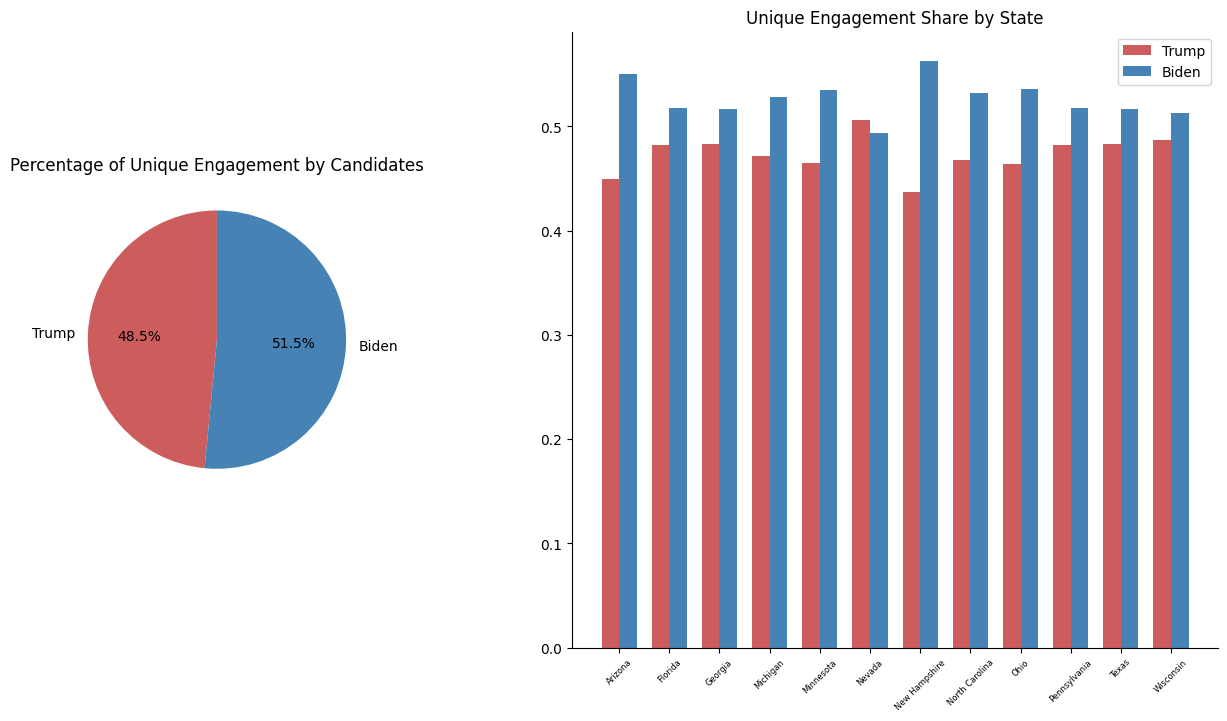

In [63]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 2]})



trump_tweets = 23481
biden_tweets = 24961


trump_percent = (trump_tweets / (trump_tweets + biden_tweets)) * 100
biden_percent = (biden_tweets / (trump_tweets + biden_tweets)) * 100

#  a list of colors for the pie chart
colors1 = ['indianred', 'steelblue']

# a list of labels for the pie chart
labels1 = ['Trump', 'Biden']

# a list of sizes for the pie chart
sizes1 = [trump_percent, biden_percent]

# pie chart
ax1.pie(sizes1, labels=labels1, colors=colors1, autopct='%1.1f%%', startangle=90)

#  title
ax1.set_title('Percentage of Unique Engagement by Candidates')


#  the width of the bars
bar_width = 0.35

#  a list of x positions for the bars
x = np.arange(len(swing))
ax2.set_xticks(x)
ax2.set_xticklabels(swing.state)
ax2.tick_params(axis='x', labelsize=6)
plt.xticks(rotation=45)


#  a list of colors for the bars
colors2 = ['indianred', 'steelblue']


# the bar plot
ax2.bar(x - bar_width/2, swing['trump_engagement_share'], width=bar_width, color=colors2[0], label='Trump')
ax2.bar(x + bar_width/2, swing['biden_engagement_share'], width=bar_width, color=colors2[1], label='Biden')


#  a title and legend
ax2.set_title('Unique Engagement Share by State')
ax2.legend()

# Adjust spacing between subplots
fig.subplots_adjust(wspace=0.4)

#remove spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

#  the figure
plt.show()


One of the variables we have selected for analysis is the unique engagement for each candidate. The assumption underlying this variable is that identifying unique user IDs that tweeted about a candidate can provide insight into how many people are interested in that particular candidate. It is important to emphasize that we are focusing on unique user IDs because users typically tweet multiple times, and therefore, calculating the share of tweets for each candidate in all states could be misleading. However, identifying unique user IDs that tweeted about each candidate can provide a better estimate of the actual public engagement with that candidate.

Our exploration revealed that there is generally higher engagement with Joe Biden than with Donald Trump. Among all users who tweeted about both candidates, more people tweeted about Biden than Trump. This trend is evident in the bar plot, which shows higher engagement with Biden in every battleground state. Since Trump had been in power before the election, it is likely that there was more interest and discussion about Joe Biden than Trump. Therefore, using engagement share as a predictor of the election outcome would not be wise, as it would likely favor Biden in most states. Furthermore, previous research has shown that Twitter users tend to be more left-leaning and liberal compared to the general population in the United States (Woolley & Howard, 2016). This might explain why we see higher engagement with Joe Biden in our dataset, as Democrats tend to use social media platforms more actively to express their political opinions and engage in political discourse.

It is worth noting that higher engagement with Biden was not limited to battleground states but was also observed in most states across the US.



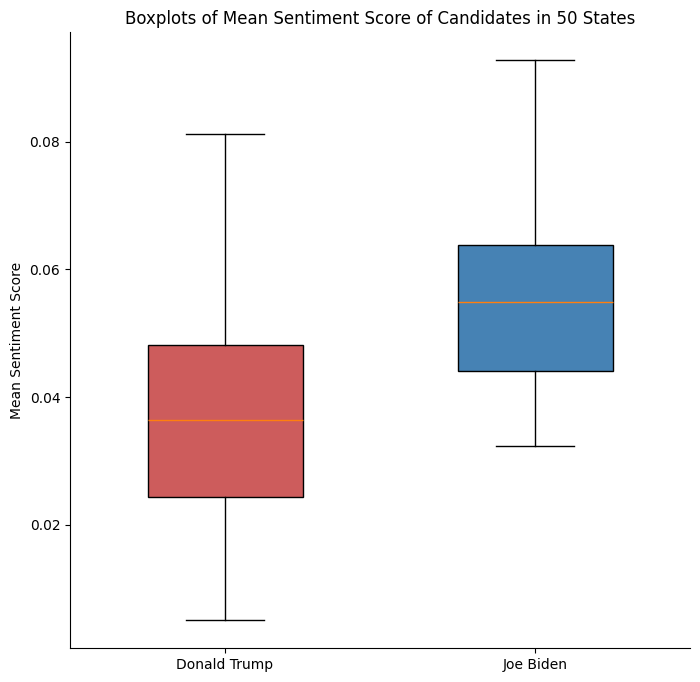

In [64]:
trump = sentiment_results['trump_mean_score']
biden = sentiment_results['biden_mean_score']


fig, ax = plt.subplots(figsize=(8,8))
bgcolor = 'white'


# Increase font size and make it bolder
font = {'family': 'Arial', 'weight': 'bold', 'size': 10}
plt.rc('font', **font)


#  the first boxplot
bp1 = ax.boxplot(trump, positions=[1], widths=0.5, patch_artist=True, boxprops=dict(facecolor='IndianRed'))

#  the second boxplot
bp2 = ax.boxplot(biden, positions=[2], widths=0.5, patch_artist=True, boxprops=dict(facecolor='SteelBlue'))

# Add colors and labels to the plot
bp1['boxes'][0].set_facecolor('IndianRed')
bp2['boxes'][0].set_facecolor('SteelBlue')
ax.set_xticks([1, 2])
ax.set_xticklabels(['Donald Trump', 'Joe Biden'])
ax.set_ylabel('Mean Sentiment Score')
ax.set_title('Boxplots of Mean Sentiment Score of Candidates in 50 States')

# Add annotations to the plot
ax.annotate('Significant Difference', xy=(1.5, 2), xytext=(1.5, 3),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_facecolor(bgcolor)


# Show the plot
plt.show()


The boxplot depicted above showcases the distribution of the mean sentiment scores of the two presidential candidates in all the states. From the plot, it is quite evident that the median value of the mean sentiment score of Biden is higher than that of Trump. The symmetry of the boxes indicates that the mean of the mean sentiment scores for both the candidates is close to their respective medians. This information suggests that in all the states, on average, the public had a more positive sentiment towards Biden than towards Trump. 


Additionally, we observe that the spread of the mean sentiment scores for Trump is higher than that of Biden. One plausible explanation for this could be the fact that Biden had a substantially higher number of tweets than Trump. As a result, the variance in sentiment scores is lower for Biden. This is a crucial observation as it allows us to anticipate a stronger correlation between variables in the case of Trump than in that of Biden.

In [65]:
import seaborn as sns

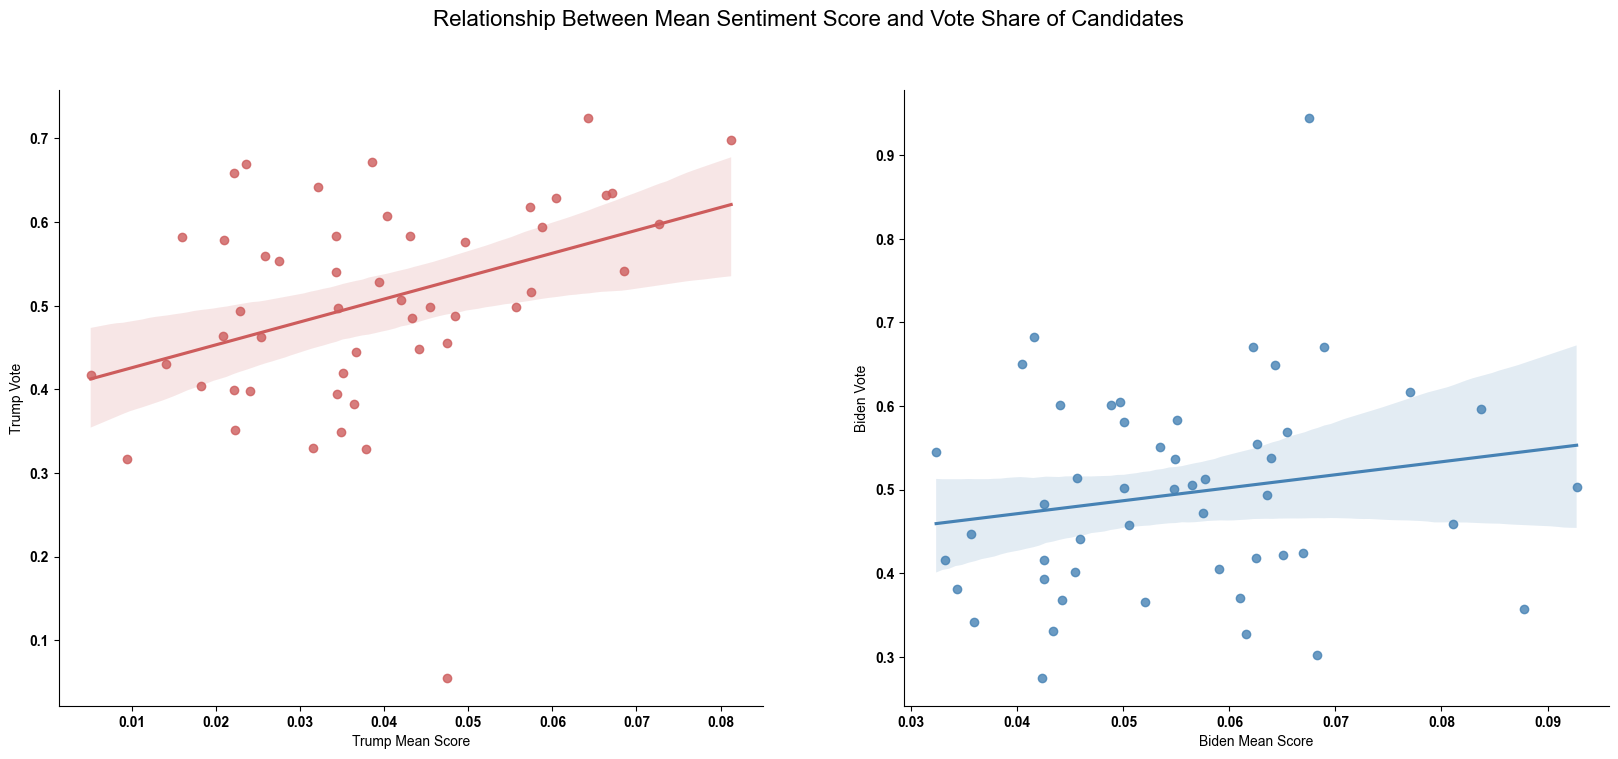

In [66]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8))


sns.regplot(x='trump_mean_score', y='trump_vote', data=states, ax=ax1, color='indianred', scatter_kws={})
ax1.set_xlabel('Trump Mean Score')
ax1.set_ylabel('Trump Vote')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

sns.regplot(x='biden_mean_score', y='biden_vote', data=states, ax=ax2, color='steelblue', scatter_kws={})
ax2.set_xlabel('Biden Mean Score')
ax2.set_ylabel('Biden Vote')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

fig.suptitle('Relationship Between Mean Sentiment Score and Vote Share of Candidates', fontsize=16)


plt.show()


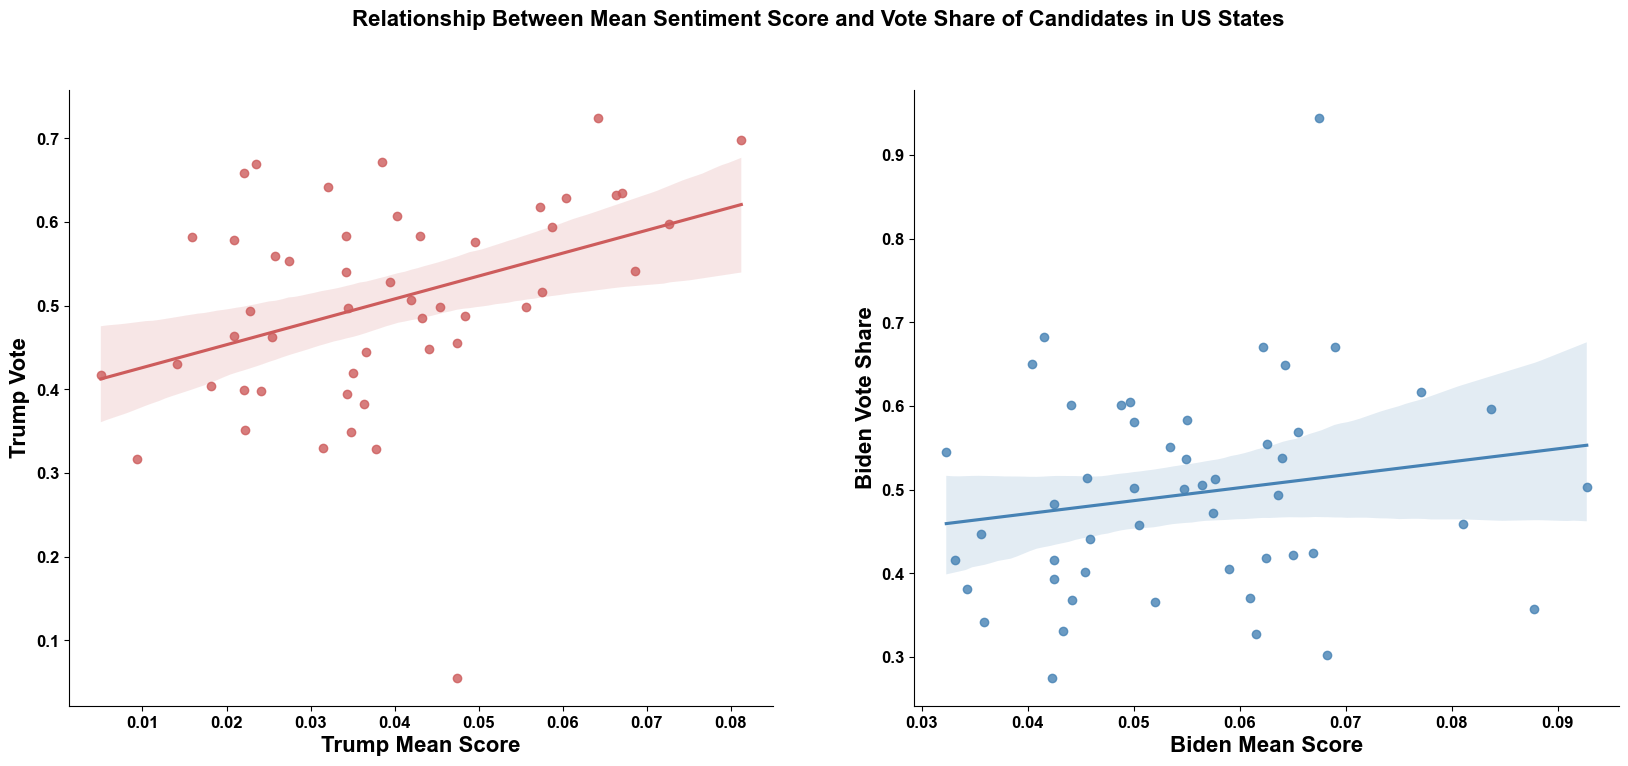

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Increase font size and make it bolder
font = {'family': 'Arial', 'weight': 'bold', 'size': 25}
plt.rc('font', **font)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.regplot(x='trump_mean_score', y='trump_vote', data=states, ax=ax1, color='indianred', scatter_kws={})
ax1.set_xlabel('Trump Mean Score', fontweight='bold', fontsize=16)
ax1.set_ylabel('Trump Vote', fontweight='bold', fontsize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(labelsize=12)  # Increase tick labels font size

sns.regplot(x='biden_mean_score', y='biden_vote', data=states, ax=ax2, color='steelblue', scatter_kws={})
ax2.set_xlabel('Biden Mean Score', fontweight='bold', fontsize=16)
ax2.set_ylabel('Biden Vote Share', fontweight='bold', fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(labelsize=12)  # Increase tick labels font size

fig.suptitle('Relationship Between Mean Sentiment Score and Vote Share of Candidates in US States', fontsize=16, fontweight='bold')

plt.show()


The above plot displays the relationship between the mean sentiment scores of each state and the vote share of the candidate. This plot was generated based on the assumption that if a candidate has a higher mean sentiment score in any state, they are expected to have a higher number of votes. We can see that there is an evident positive correlation between the mean sentiment score of Trump in the US states with his share of votes. As expected, the correlation in the scatter plot of Trump is stronger and more evident than that of Biden. This is due to Biden having a huge number of tweets and engagements during the election. This observation is important for us. After all, a positive correlation between mean sentiment score and vote share tells us that we can use the mean sentiment score to predict the outcome of an election in each state. 

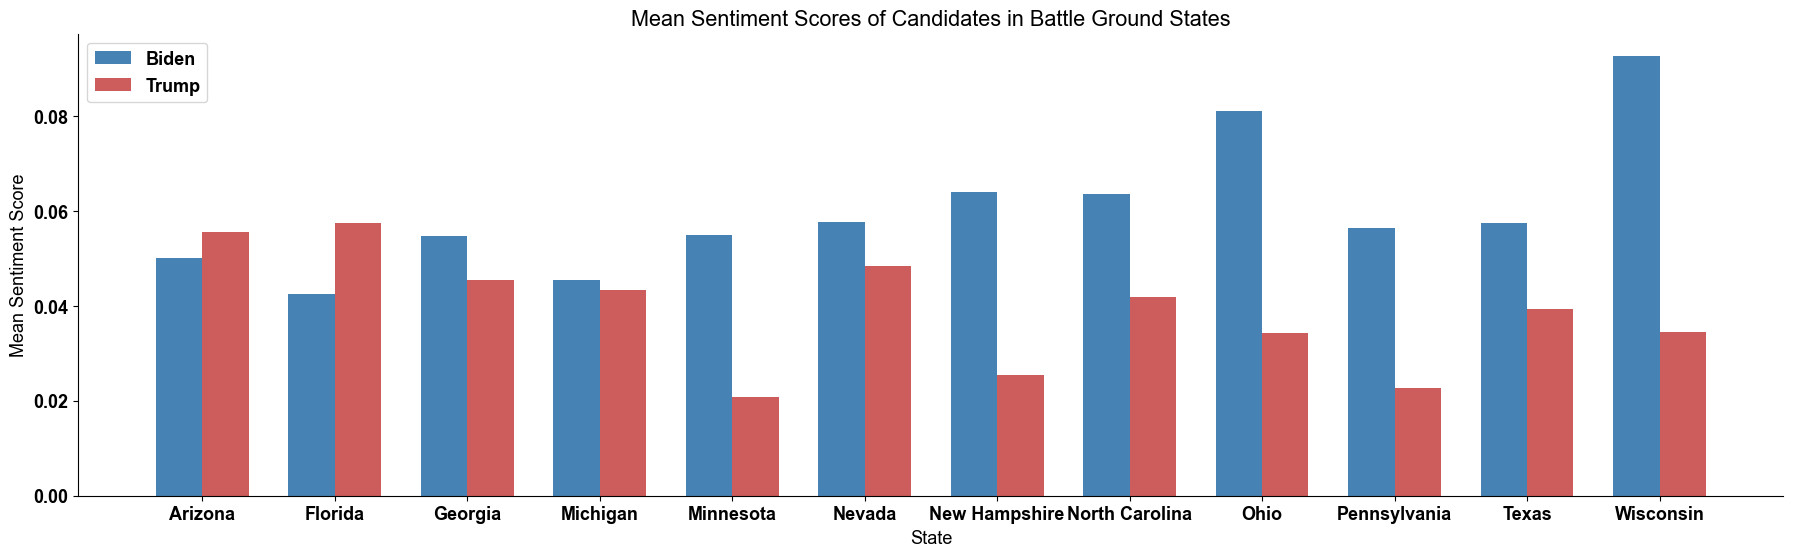

In [68]:
# plot the bars


font = {'family': 'Arial', 'weight': 'bold', 'size': 13}
plt.rc('font', **font)


fig, ax = plt.subplots(figsize=(22, 6))
bar_width = 0.35
x = np.arange(len(bgs['state']))
ax.bar(x - bar_width/2, bgs['biden_mean_score'], width=bar_width, color='steelblue', label='Biden')
ax.bar(x + bar_width/2, bgs['trump_mean_score'], width=bar_width, color='indianred', label='Trump')

# set the title and axis labels
ax.set_title('Mean Sentiment Scores of Candidates in Battle Ground States')
ax.set_xlabel('State')
ax.set_ylabel('Mean Sentiment Score')

# set the ticks and labels for the x-axis
ax.set_xticks(x)
ax.set_xticklabels(bgs['state'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


# add a legend
ax.legend()


plt.show()


The term "battleground state" (sometimes referred to as a "swing state" or a "purple state") refers to a state where the outcome of an election is uncertain or where neither political party has a certain advantage. Due to the potential importance of the outcomes in these states in determining the outcome of the presidential election, these states are heavily targeted by political campaigns and receive a lot of media coverage during elections. The states that make up the list of "battleground" states tend to be those with a history of supporting both Democratic and Republican candidates and have a sizable number of electoral votes at stake. In the above plot, we have shown the comparison of mean sentiment scores of the candidate in the states that were considered 'battlegrounds' during the 2020 elections. In most states, except for Arizona, North Carolina, Ohio and Texas, the mean sentiment score for the winning candidate was actually higher. This means our model accurately predicts the outcomes in 67% of all the battleground states. In Arizona, Joe Biden received 49.4% of the vote in Arizona, while Donald Trump received 49.1% , with other candidates receiving the remaining 1.5%. It means that Joe Biden won by a margin of 0.3% only. We can see that in Arizona, the difference between the mean sentiment score is quite low as well. In Texas, Donald Trump won by a margin of 5.6%, and we can see from our plot that the difference in mean sentiment score wasn't too big as well. Although, in Ohio, our plot shows a big difference in mean sentiment score between Biden and Trump, eventhough Trump won by a margin of 8.1%, which doesn't align with our prediction. Nevertheless, as we received 8 out of 12 successes in the battleground states, this prediction variable looks promising for future predictions of elections. 

The above plot displays the distribution of tweet counts within counties and states. Our data includes tweets from only 876 out of the 3,143 counties in the US, and the majority of these counties had a significantly low count of tweets. This indicates that Twitter usage is extremely disproportionate within counties, and the mean count of tweets in counties is low, with several outliers. Additionally, 50% of counties had less than 15 tweets. However, Twitter usage amongst states is not as disproportionate, with 50% of states having more than 1,768 tweets. Therefore, it would be better to perform our analysis at the state level and predict state outcomes, as we would have sufficient tweets from each state to make an accurate prediction. It would not be wise to analyze counties as the low count of tweets from each county would not provide any insightful analysis.

#### *Project2*

#### **The Message**

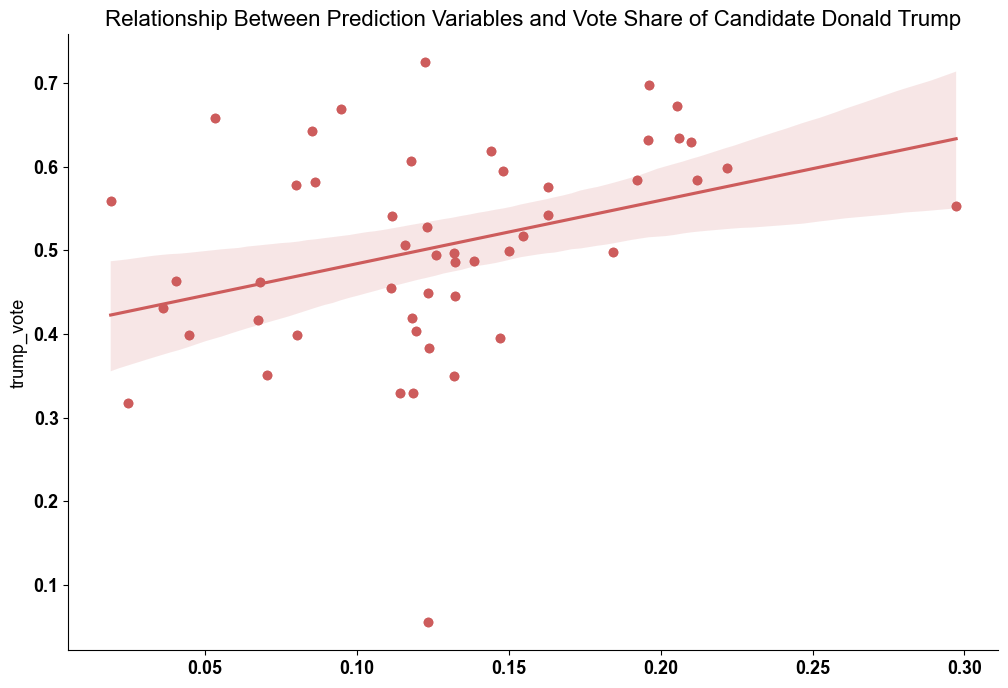

In [70]:
import matplotlib.pyplot as plt

fig, ax3 = plt.subplots(figsize=(12, 8))

ax3.scatter(states['trump_positive_share'] - states['trump_negative_share'], states['trump_vote'], color='IndianRed')
ax3.set_xlabel('Prediction Score [Positive Share - Negative Share]')
ax3.set_ylabel('Trump Vote Share')

# Fit a regression line
sns.regplot(x=states['trump_positive_share'] - states['trump_negative_share'], y=states['trump_vote'], ax=ax3, color='IndianRed')

# Turn off the top and right spines
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax3.set_title('Relationship Between Prediction Variables and Vote Share of Candidate Donald Trump', fontsize=16)



# Display the plot
plt.show()


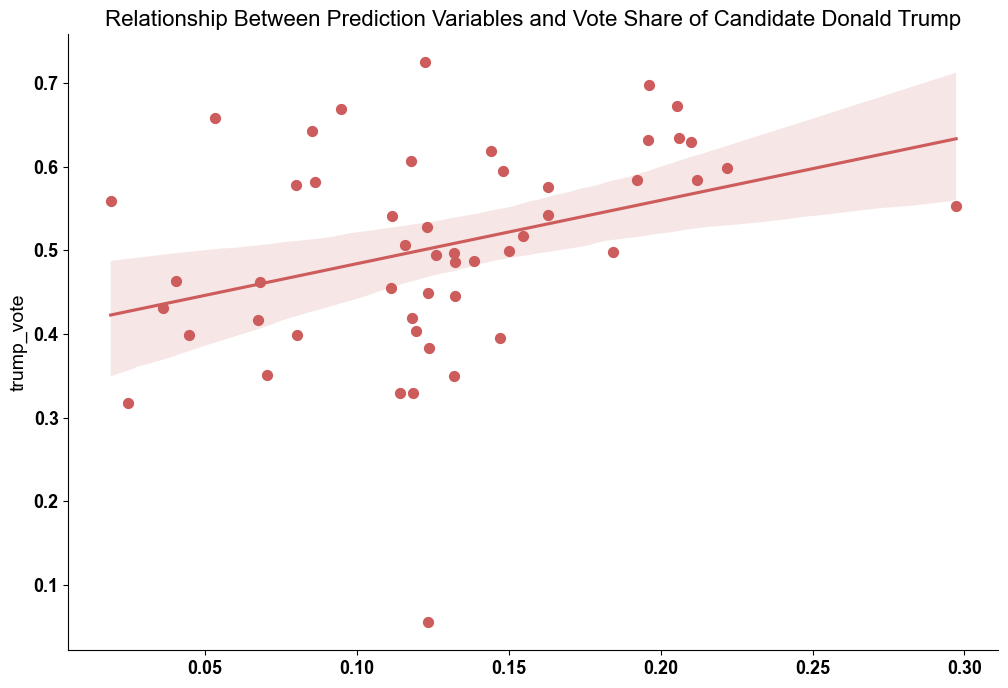

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax3 = plt.subplots(figsize=(12, 8))

# Adjust dot size and font visibility
dot_size = 50
font = {'family': 'Arial', 'weight': 'bold', 'size': 12}
plt.rc('font', **font)

# Scatter plot
ax3.scatter(states['trump_positive_share'] - states['trump_negative_share'], states['trump_vote'], color='IndianRed', s=dot_size)
ax3.set_xlabel('Positivity Score', fontsize=14)
ax3.set_ylabel("Trump's Vote Share", fontsize=14)

# Fit a regression line
sns.regplot(x=states['trump_positive_share'] - states['trump_negative_share'], y=states['trump_vote'], ax=ax3, color='IndianRed')

# Turn off the top and right spines
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax3.set_title('Relationship Between Prediction Variables and Vote Share of Candidate Donald Trump', fontsize=16)

# Display the plot
plt.show()


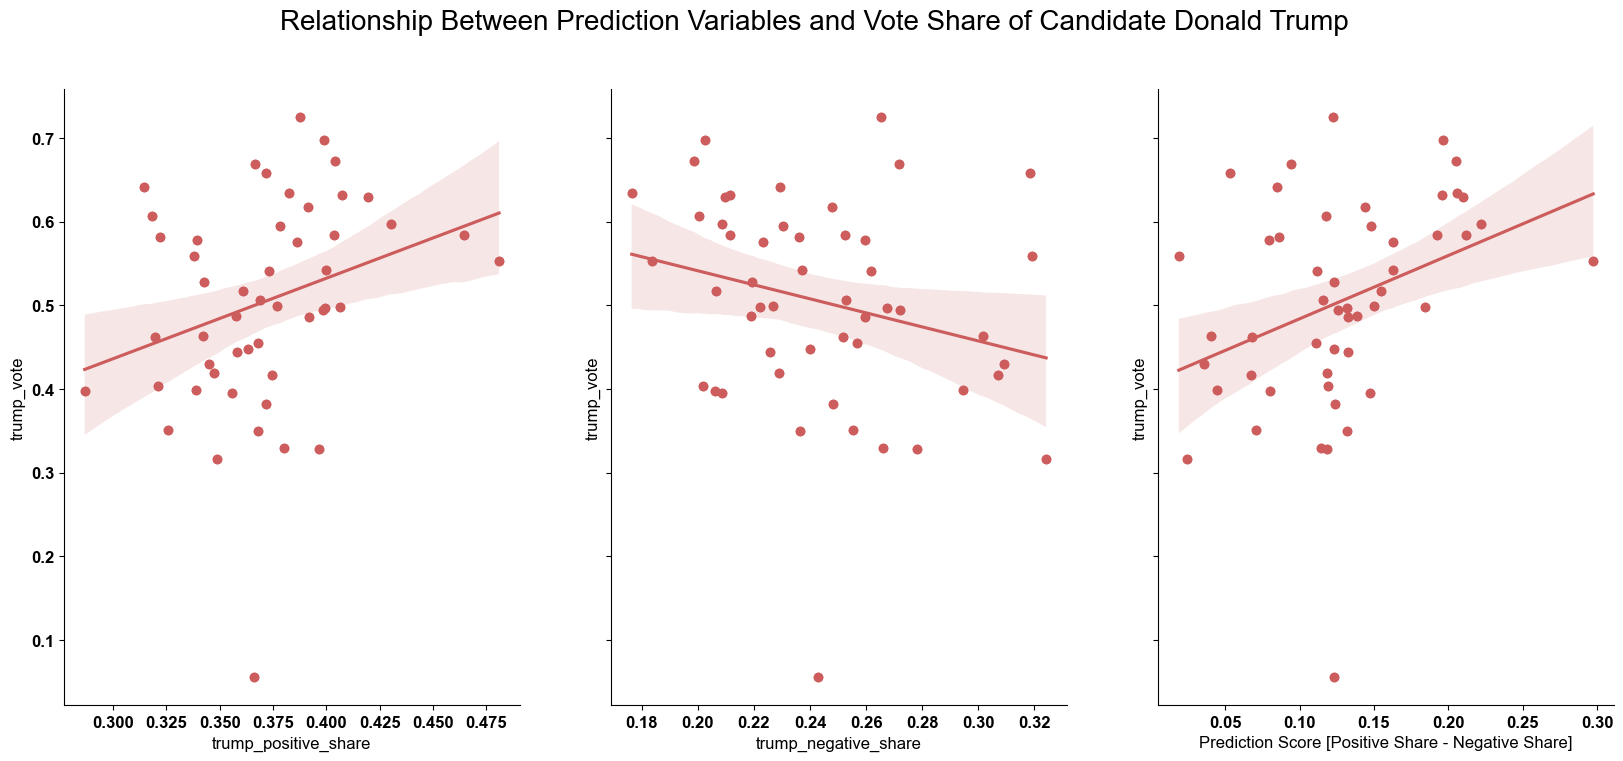

In [72]:



fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(20, 8))

axs[0].scatter(states['trump_positive_share'], states['trump_vote'], color='IndianRed')
axs[0].set_xlabel('Positive Share of Tweets')
axs[0].set_ylabel('Trump Vote Share')




sns.regplot(x=states['trump_positive_share'], y=states['trump_vote'], ax=axs[0], color='IndianRed')


axs[1].scatter(states['trump_negative_share'], states['trump_vote'], color='IndianRed')
axs[1].set_xlabel('Negative Share of Tweets')


sns.regplot(x=states['trump_negative_share'], y=states['trump_vote'], ax=axs[1], color='IndianRed')


axs[2].scatter(states['trump_positive_share'] - states['trump_negative_share'], states['trump_vote'], color='IndianRed')


sns.regplot(x=states['trump_positive_share'] - states['trump_negative_share'], y=states['trump_vote'], ax=axs[2], color='IndianRed')

# Turn off the top and right spines
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axs[2].set_xlabel('Prediction Score [Positive Share - Negative Share]')

fig.suptitle('Relationship Between Prediction Variables and Vote Share of Candidate Donald Trump', fontsize=20)

font = {'family': 'Arial', 'weight': 'bold', 'size': 10}
plt.rc('font', **font)

# Display the plot
plt.show()


This study aimed to identify the variable that exhibits the strongest correlation with vote share to find the best approach for predicting each state's election outcome. Initially, we explored the correlation between the mean sentiment score and vote count. The plot above shows the correlation between the positive share of tweets, the negative share of tweets, and a prediction score calculated by subtracting the negative share from the positive share of tweets for candidates with the vote share for Donald Trump.

We observed a clear positive correlation between the positive share of tweets and the vote share of Trump. In contrast, a negative correlation exists between the negative share of tweets and the vote share of Trump. These findings support our hypotheses that a higher positive number of tweets for a candidate leads to a higher vote share. Conversely, if a candidate receives more negative tweets, they will receive a lower vote share. Given the potential of the positive and negative shares of tweets for predicting the election outcome, we calculated the final prediction score by subtracting the negative share from the positive share.

Our reasoning behind this approach is that if a candidate receives a higher positive share of tweets and a lower negative share of tweets, then they have a better chance of winning in that state. The plot supports our assumption, as the correlation between the prediction score and vote counts is the strongest among all the correlations observed so far. This result indicates that this prediction score will likely provide the highest number of successes.

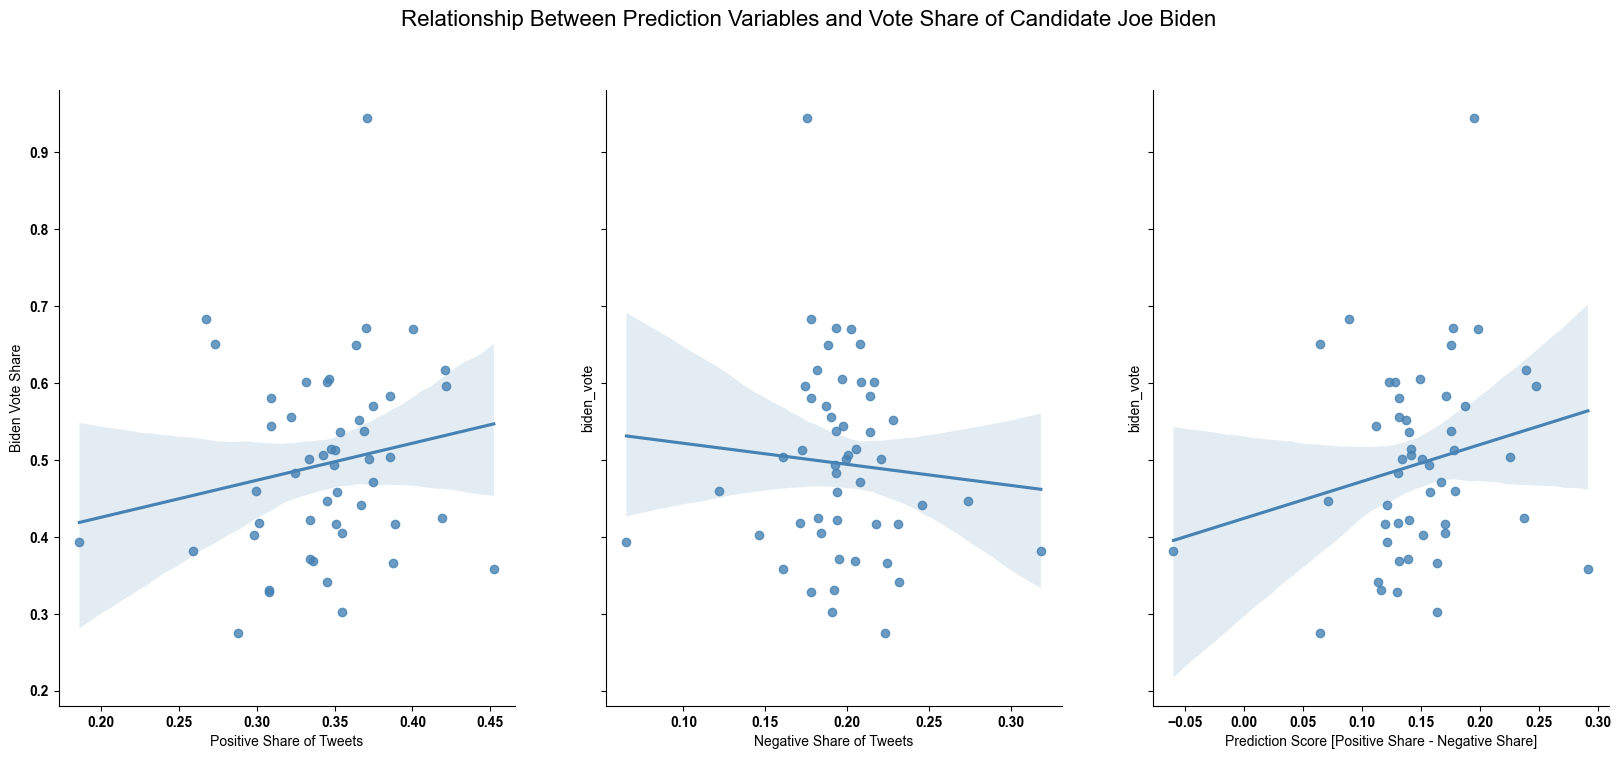

In [73]:

fig, axs = plt.subplots(ncols=3, sharey=True, figsize=(20, 8))

sns.regplot(x=states['biden_positive_share'], y=states['biden_vote'], color='steelblue', ax=axs[0])
axs[0].set_xlabel('Positive Share of Tweets')
axs[0].set_ylabel('Biden Vote Share')


sns.regplot(x=states['biden_negative_share'], y=states['biden_vote'], color='steelblue', ax=axs[1])
axs[1].set_xlabel('Negative Share of Tweets')

sns.regplot(x=states['biden_positive_share'] - states['biden_negative_share'], y=states['biden_vote'], color='steelblue', ax=axs[2])
axs[2].set_xlabel('Prediction Score [Positive Share - Negative Share]')


for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
fig.suptitle('Relationship Between Prediction Variables and Vote Share of Candidate Joe Biden', fontsize=16)

# Display the plot
plt.show()


The plot above illustrates the association between the positive share of tweets, the negative share of tweets, and the prediction score with the vote share for Biden. Although the correlation is less clear than that of Trump, we can still observe a positive correlation between the positive share of tweets and vote share, and a negative correlation between the negative share of tweets and vote share for Biden. Additionally, the correlation between the prediction score and vote share of Biden is relatively stronger. Thus, in states where Joe Biden received a higher proportion of positive tweets and a lower proportion of negative tweets, he tended to have a higher vote share.

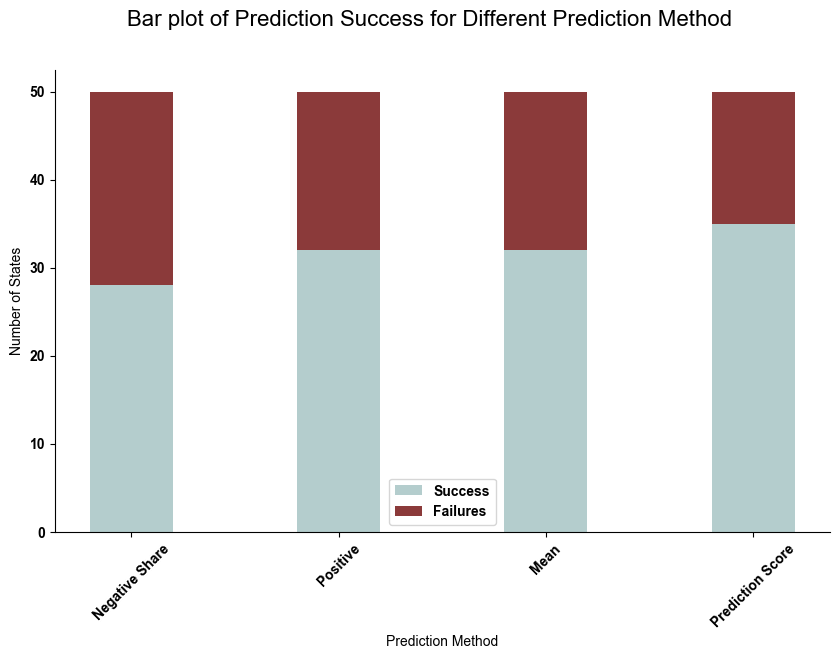

In [74]:
#data frame of number of success and failures
data = {'Prediction Method': ['Negative Share', 'Positive', 'Mean', 'Prediction Score'],
        'Success': [28, 32, 32, 35],
        'Failures': [22, 18, 18, 15]}
outcome = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(outcome['Prediction Method'], outcome['Success'], color='#B4CDCD',width=0.4, label='Success')
ax.bar(outcome['Prediction Method'], outcome['Failures'], color='#8B3A3A', bottom=outcome['Success'], width=0.4, label='Failures')

# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# set x-axis label and tick labels
ax.set_xlabel('Prediction Method')
ax.set_xticklabels(outcome['Prediction Method'], rotation=45)

ax.set_ylabel('Number of States')
ax.set_yticks([0, 10, 20, 30, 40, 50])

# set legend
ax.legend()

fig.suptitle('Bar plot of Prediction Success for Different Prediction Method', fontsize=16)

# show the plot
plt.show()


The plot above displays the success and failure rates for each prediction method used. The first method compares the proportion of negative tweets between each candidate and assumes that a lower portion of negative tweets is indicative of a likely win in the corresponding state. This approach yields a success rate of 28 out of 50 states, and 8 out of 12 battleground states. The second method, using a positive share of tweets, assumes that a candidate with more positive tweets is likely to win in that state. This approach achieves a higher success rate of 32 states, with failures in only four battleground states, indicating it to be a better predictor than the previous method. The mean sentiment score method has a similar number of successes and failures to the positive share method. Finally, the prediction score method results in the lowest number of failures with a success rate of 35 out of 50 states, or 70%. It fails in only four out of the 12 battleground states, making it the most effective predictor. The key takeaway is that a candidate with a lower share of negative tweets and a higher share of positive tweets is likely to win in that state.

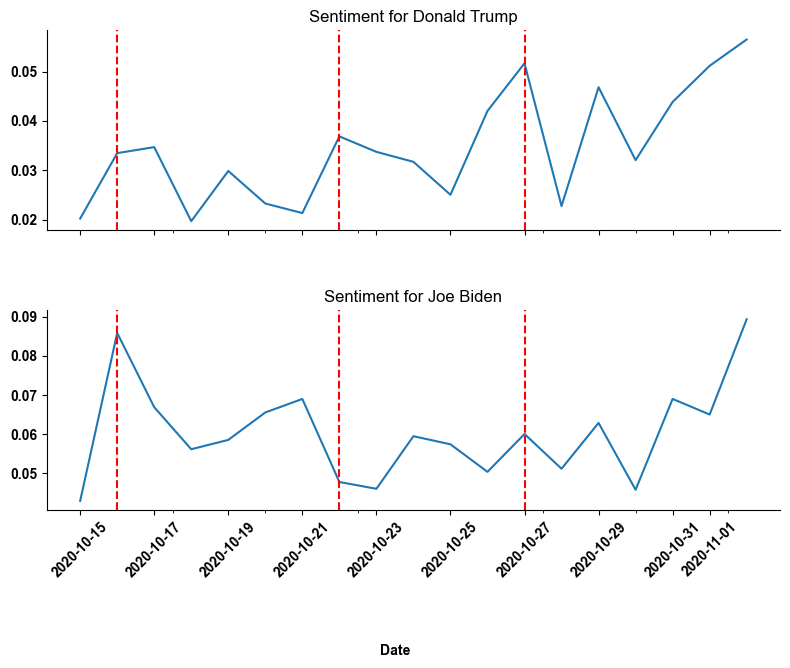

In [75]:
# convert the 'created_at' column to a pandas datetime object
df2['created_at'] = pd.to_datetime(df2['created_at'])

# create two new dataframes for each candidate
df_trump = df2[df2['candidate'] == 'Donald Trump']
df_biden = df2[df2['candidate'] == 'Joe Biden']

# create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

# plot sentiment for Trump on ax1
df_trump.groupby(df_trump['created_at'].dt.date)['sentiment score'].mean().plot(ax=ax1)
ax1.set_title('Sentiment for Donald Trump')
ax1.axvline(pd.to_datetime('2020-10-16'), color='r', linestyle='--')
ax1.axvline(pd.to_datetime('2020-10-22'), color='r', linestyle='--')
ax1.axvline(pd.to_datetime('2020-10-27'), color='r', linestyle='--')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', rotation=45)

# plot sentiment for Biden on ax2
df_biden.groupby(df_biden['created_at'].dt.date)['sentiment score'].mean().plot(ax=ax2)
ax2.set_title('Sentiment for Joe Biden')
ax2.axvline(pd.to_datetime('2020-10-16'), color='r', linestyle='--')
ax2.axvline(pd.to_datetime('2020-10-22'), color='r', linestyle='--')
ax2.axvline(pd.to_datetime('2020-10-27'), color='r', linestyle='--')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='x', rotation=45)
ax2.set_xlabel('')

# add a common x-axis label and adjust spacing
plt.tight_layout()
fig.text(0.5, -0.1, 'Date', ha='center')
plt.subplots_adjust(hspace=0.4)

# display the plot
plt.show()


The plots show the time series graph of sentiment towards Joe Biden and Donald Trump during the 2020 US presidential election. One interesting event during that period was the presidential debate held on October 22nd in Tennessee. After the debate, the mean sentiment score for Trump experienced a sharper decrease compared to that of Biden. This may have been due to his controversial behavior during the debate, which resulted in negative sentiment towards him.

However, we can see another significant drop in sentiment towards Trump on October 27th, which can be attributed to multiple factors. One major event was the confirmation of Amy Coney Barrett to the Supreme Court by the Senate, which was seen as a victory for Trump and the Republicans but opposed by many Democrats. Another major news event on October 27 was the ongoing COVID-19 pandemic, which was causing a surge in cases and hospitalizations in the United States, leading to criticism of the government's response to the crisis. Trump was also criticized for downplaying the severity of the virus and his administration's handling of the pandemic.

Additionally, Trump's response to the nationwide protests following the killing of George Floyd in May 2020 was also criticized. On October 27th, a grand jury in Philadelphia declined to charge the police officers involved in the killing of Walter Wallace Jr., a Black man who was shot and killed by police during a mental health crisis. This event may have contributed to ongoing discussions about police brutality and racial injustice, which were major themes in the 2020 election.

Trump's loss in the election can be attributed to his indifference towards the COVID-19 pandemic and the Black Lives Matter movement. The data shows that these factors impacted public sentiment towards him, resulting in a decrease in his overall approval ratings.

On the other hand, the most norable spike on Joe Biden's sentiment was On October 15th. We can see that there is a sharp fall in sentiment on that day. One factor that could have influenced sentiment towards Biden was the ongoing controversy over his son Hunter Biden's business dealings in Ukraine and China.

In Summarry, twitter data can be a useful tool to analyze how the actions of political candidates and other events can impact public sentiment leading up to an election. By monitoring changes in sentiment over time, it is possible to identify trends and patterns that may shed light on how voters are responding to specific events or issues. 

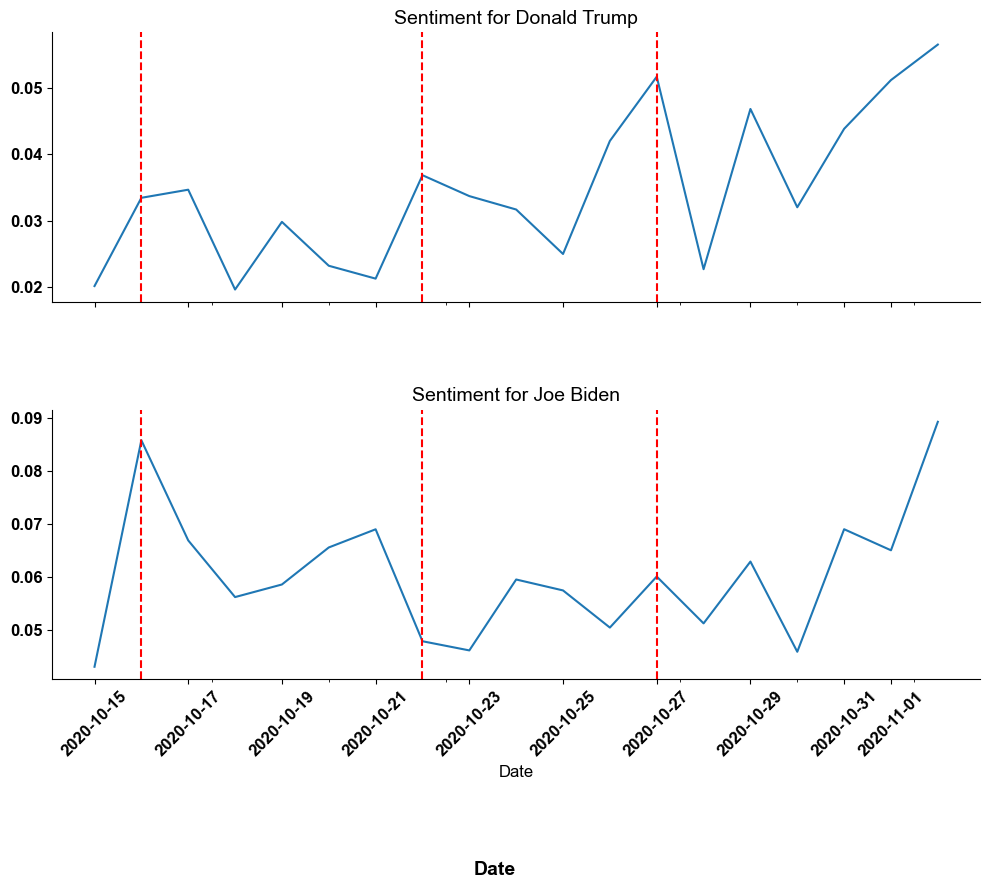

In [76]:
import matplotlib.pyplot as plt

# convert the 'created_at' column to a pandas datetime object
df2['created_at'] = pd.to_datetime(df2['created_at'])

# create two new dataframes for each candidate
df_trump = df2[df2['candidate'] == 'Donald Trump']
df_biden = df2[df2['candidate'] == 'Joe Biden']

# create two subplots with larger font sizes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# plot sentiment for Trump on ax1
df_trump.groupby(df_trump['created_at'].dt.date)['sentiment score'].mean().plot(ax=ax1)
ax1.set_title('Sentiment for Donald Trump', fontsize=14)
ax1.axvline(pd.to_datetime('2020-10-16'), color='r', linestyle='--')
ax1.axvline(pd.to_datetime('2020-10-22'), color='r', linestyle='--')
ax1.axvline(pd.to_datetime('2020-10-27'), color='r', linestyle='--')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.tick_params(axis='x', rotation=45, labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

# plot sentiment for Biden on ax2
df_biden.groupby(df_biden['created_at'].dt.date)['sentiment score'].mean().plot(ax=ax2)
ax2.set_title('Sentiment for Joe Biden', fontsize=14)
ax2.axvline(pd.to_datetime('2020-10-16'), color='r', linestyle='--')
ax2.axvline(pd.to_datetime('2020-10-22'), color='r', linestyle='--')
ax2.axvline(pd.to_datetime('2020-10-27'), color='r', linestyle='--')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.tick_params(axis='x', rotation=45, labelsize=12)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_xlabel('Date', fontsize=12)

# add a common x-axis label and adjust spacing
plt.tight_layout()
fig.text(0.5, -0.1, 'Date', ha='center', fontsize=14)
plt.subplots_adjust(hspace=0.4)

# display the plot
plt.show()


#### **Maps and Interpretation**

In [79]:
fips = pd.read_csv("2014_usa_states.csv")
vote_fips = pd.merge(vote, fips, left_on="state", right_on="State", how="left")
victory = pd.merge(victory, fips, on='State')

In [80]:
vote_fips.describe()

,trump_vote,biden_vote,Rank,Population
count,51.000000,51.000000,51.000000,5.100000e+01
mean,0.502814,0.497186,26.235294,6.252099e+06
std,0.123338,0.123338,15.183660,7.124005e+06
min,0.055330,0.275196,1.000000,5.841530e+05
25%,0.418108,0.410692,13.500000,1.742395e+06
50%,0.498807,0.501193,26.000000,4.413457e+06
75%,0.589308,0.581892,38.500000,6.903469e+06
max,0.724804,0.944670,52.000000,3.880250e+07


In [81]:
import plotly.express as px

# create custom color scale
colorscale = [
    [0, 'rgb(5, 48, 97)'],
    [0.25, 'rgb(33, 113, 181)'],
    [0.5, 'rgb(222, 235, 247)'],
    [0.75, 'rgb(239, 138, 98)'],
    [1, 'rgb(178, 24, 43)']
]

# create choropleth map
fig = px.choropleth(locations=vote_fips['Postal'],
                    locationmode="USA-states",
                    color=vote_fips['trump_vote'],
                    scope="usa",
                    range_color=[.04, 0.85],
                    color_continuous_scale=colorscale,
                    labels={'trump_vote': 'Trump Vote Share'})

# update colorscale and colorbar
fig.update_traces(marker_line_width=0.5, marker_line_color='white')
fig.update_layout(coloraxis_colorbar=dict(
    title='Trump Vote Share',
    thicknessmode="pixels", thickness=15,
    lenmode="pixels", len=300,
    yanchor="top", y=1,
    ticks="outside", ticksuffix="%",
    dtick=0.1, tickfont=dict(size=10),
))

fig.add_scattergeo(
    locations= vote_fips['Postal'],
    locationmode="USA-states", 
    text= vote_fips['Postal'],
    mode='text',
    textfont=dict(color='#664400')
) 



fig.update_layout(
    title={
        'text': 'Vote Share of Trump in US States',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

# show the plot
fig.show()


From the above map, we can see the vote share of candidates in each state. Note that the vote share is calculated on the basis of the total votes won by Joe Biden and Donald Trump. The redder region denotes the states where Trump had a higher share of votes, and the bluer region denotes where Biden had a higher share of votes. The region where Trump's vote share is between 0.5 to 0.6 denotes the region where he won by a very thin margin. It is crucial for our research, as in many of these states, our prediction failed only due to the candidate winning by a thin margin of vote shares. Despite our candidates having a higher prediction score, our prediction failed due to this thin margin of votes. As we look at our map for success and failures of prediction outcomes, we will see that most of our failures actually fall within the range of a thin margin. 

In [82]:
vote_fips= pd.merge(vote_fips,state_code, on='state')
score_data = category[['state','trump_score','biden_score']]
score_data['trump_score'] = score_data['trump_score']/(score_data['trump_score']+score_data['biden_score'])
score_data['biden_score'] = score_data['biden_score']/(score_data['trump_score']+score_data['biden_score'])
score_fips = pd.merge(score_data, fips, left_on="state", right_on="State", how="left")
cat_fips = pd.merge(category, fips, left_on="state", right_on="State", how="left")

In [83]:
#mking the map for predcition faouribility of trump
colorscale = [
    [0, 'rgb(5, 48, 97)'],
    [0.25, 'rgb(33, 113, 181)'],
    [0.5, 'rgb(222, 235, 247)'],
    [0.75, 'rgb(239, 138, 98)'],
    [1, 'rgb(178, 24, 43)']
]

#  map
fig = px.choropleth(locations=score_fips['Postal'],
                    locationmode="USA-states",
                    color=score_fips['trump_score'],
                    scope="usa",
                    range_color=[.04, 0.85],
                    color_continuous_scale=colorscale,
                    labels={'trump_score': 'Trump Vote Share'})

# colorscale and colorbar
fig.update_traces(marker_line_width=0.5, marker_line_color='white')
fig.update_layout(coloraxis_colorbar=dict(
    title='Prediction Favourabity for Trump',
    thicknessmode="pixels", thickness=15,
    lenmode="pixels", len=300,
    yanchor="top", y=1,
    ticks="outside", ticksuffix="%",
    dtick=0.1, tickfont=dict(size=10),
))

fig.add_scattergeo(
    locations= score_fips['Postal'],
    locationmode="USA-states", 
    text= score_fips['Postal'],
    mode='text',
    textfont=dict(color='#664400')
) 

fig.update_layout(
    title={
        'text': 'Prediction for Candidates',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

#  plot
fig.show()

The above map shows the prediction favourability of Trump. We have plotted this map based on the proportion of prediction scores won by Trump. So, the redder region denotes a region where Donald Trump had more positive tweets and lower negative tweets. We can see that Tennesse had the highest prediction favourability for Trump. In Tennesse, in comparison to Joe Biden, Trump had a higher number of positive tweets and a lower number of negative tweets. This makes sense as Donald Trump won the highest number of votes in Tennessee in the 2020 US Presidential Election. Trump received approximately 1.85 million votes in Tennessee, while Joe Biden received approximately 1.17 million votes in the state. Similarly, we can see that Trump had a high favourability in the state of Alaska. This also makes sense in the 2020 US Election. Trump received approximately 53.5% of the vote in Alaska, while Biden received approximately 43.7%. This map attests to the fact that using the prediction score for candidates is the best approach to predicting the election outcome. Afterall, according to our predicition in states line Tennesse and Alaska Donald Trump is supposed to receieve a higher fraction of vote share, which actually happened in Alaska and Tennesse. 

In [84]:

#Making the map for prediction success and Failures
fig = px.choropleth(locations=cat_fips['Postal'],
                    locationmode="USA-states",
                    color=cat_fips['Prediction Outcome'],
                    scope="usa",
                    range_color=[0, 1],
        
                    labels={'Prediction Outcome': 'Prediction Outcome'})

fig.add_scattergeo(
    locations= cat_fips['Postal'],
    locationmode="USA-states", 
    text= cat_fips['Postal'],
    mode='text',
    textfont=dict(color='#664400')
) 
                    
fig.update_layout(
    title={
        'text': 'Prediction Success or Failures by State',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
      


fig.show()

The above map shows the states where our prediction succeeded or failed. From here we can see that out of the 15 states where our prediction failed many of it falls within the states that had a thin margin of victory. Furthermore, using our map of prediciton favourabilty and election outcome we can see that in most of the states where our prediction had failed, we had predicted the winner to be Joe Biden as it had a higher prediction favouribilty. We believe that the reason our model predicted Joe Biden to be the winner, when in fact Trump won is because of the higher engagement of Joe Biden in each states. All of our analysis tells us that, if the engaement about both the candidates were roughly similar we might have had even better prediction of the election outcome. 

#### **Adding a New Dataset**

In 2020 US election, Biden's victory was significantly influenced by voter turnout and there are several existing literature on it. According to the U.S. Elections Project, a record-breaking high turnout of 66.4% of those eligible to vote was achieved in the 2020 election. This high turnout was driven by several factors, including the highly polarized political climate, increased attention on voting methods and access, and the COVID-19 pandemic, which motivated many voters to vote early or by mail. 

Data on voter turn out by state can complement this research. The hypothesis is that in states where individuals expressed more negative sentiment about Trump on social media platforms, there is a higher likelihood of  greater voter turnout in that states. The rationale behind this hypothesis is that negative sentiment towards a political candidate may serve as a motivating factor for individuals to participate in the election and cast their vote for the other candidate to remove Trump from power. Therefore, by examining the correlation between negative sentiment towards Trump in Twitter and voter turnout in various states, we can gain insights into the potential influence of social media sentiment on actual voter behavior.

The United States Elections Project website provides comprehensive data on voter turnout by state for the 2020 election, as well as for previous elections. The website is run by Michael McDonald, a political science professor at the University of Florida, and is widely considered to be one of the most reliable sources for election data.

Furthermore, the United States Census Beureau has demographic data corresponding to each zipcode. We can obtain the zip code of each tweet of our Data set using the latitude and longitude coordinates of each tweet. Then we can merge it with the Census data to find the the sentiment patterns of different demographic towards each candidate. We can use the merged data set to investigate how Twitter can serve as a tool to study the relationship between demographic factors and sentiment towards election candidates.

In [100]:
#reading turn out data we downloaded 
turnout = pd.read_excel('turnout.xlsx')

# Refining our turn out data to merge it with our data set 
turnout = turnout.rename(columns={'Unnamed: 5': 'Turnout_Rate'})
turnout = turnout.rename(columns={'State': 'state'})
turnout_subset = turnout[['state', 'Turnout_Rate']]
turnout_subset = turnout_subset.iloc[1:]

#merging turnout data ith our existing data
turnout_score = pd.merge(states,turnout_subset, on='state') 


In [101]:
# Replacing non-numeric values with NaN
turnout_score[['trump_negative_share', 'Turnout_Rate']] = turnout_score[['trump_negative_share', 'Turnout_Rate']].apply(pd.to_numeric, errors='coerce')

# Replacing missing values with NaN
turnout_score[['trump_negative_share', 'Turnout_Rate']] = turnout_score[['trump_negative_share', 'Turnout_Rate']].fillna(np.nan)


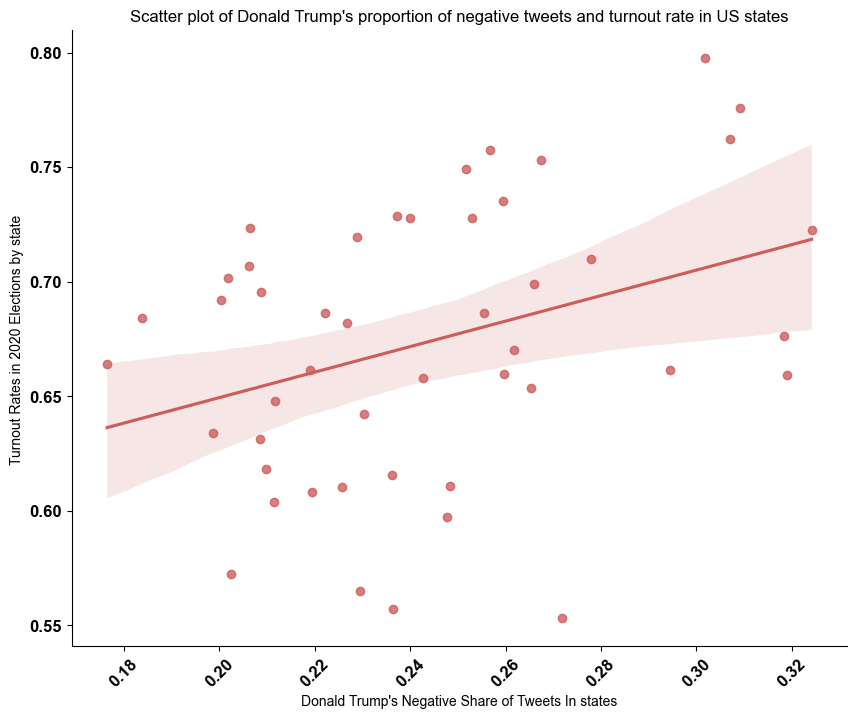

In [102]:
# Visualising turnout data 
fig, ax = plt.subplots(figsize=(10, 8))
sns.regplot(x='trump_negative_share', y='Turnout_Rate', data=turnout_score, color='indianred', ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Scatter plot of Donald Trump's proportion of negative tweets and turnout rate in US states")
ax.set_xlabel("Donald Trump's Negative Share of Tweets In states")
ax.set_ylabel("Turnout Rates in 2020 Elections by state ")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

The above figure was plotted based on the assumpton that in states where Trump's share of negative tweets are higher we might have a higher turn out rate. Our hypothesis is that negative sentiment towards Trump administration drove people to vote. We can see that in the states with the highest negative share of tweets for Trump the turn out rates are higher than 65%. On the other hand states where the Trump had low share of negatuve tweets the turn out was less than 60%. Thus we can say that tweeter sentiment can be a predictor for election turn out rate for states. 

##### OLS regression 1

We have already shown with a plot that tweet counts are extremely disproportionate amongst counties. Therefore, we do not expect a strong correlation between agggregate sentiments within counties and vote share of candidates in counties. But we will now run an OLS regression with Trump's Vote share in counties as our outcome variable and his portion of positive and negative tweets. The results of the regression will further make an argument about why we should run the regression on state level instead of county levels. 

In [ ]:
merged_df['const'] = 1

# Create lists of variables to be used in each regression
X1 = ['const', 'Trump_positive_share']
X2 = ['const', 'Trump_positive_share', 'Trump_negative_share']

# OLS regression for each set

creg1 = sm.OLS(merged_df['Trump_Vote_Share'], merged_df[X1], missing='drop').fit()
creg2 = sm.OLS(merged_df['Trump_Vote_Share'], merged_df[X2], missing='drop').fit()

In [ ]:
stargazer = Stargazer([creg1, creg2])

HTML(stargazer.render_html())

The table suggests that Trump's negative share of tweets is a statistically significant predictor of Trump's vote share at the 0.05 level of significance, but Trump's positive share of tweets is not. As we had predicted, the model as a whole is not a particularly good fit for the data, as indicated by the low R-squared value, negative adjusted R-squared value, and small F-statistic. This can be explained by the disproportionate usage of Twitter within counties, as we had highlighted before. The aggregate sentiments towards candidates in each county cannot be a predictor of vote share when 50% of counties have less than 15 tweets. Although running a regression over counties would have been beneficial due to having more data points, we showed that in this case, it won't be useful. Therefore, we will now run our regressions on state-level observations

##### OLS regression 2

Based on our analysis, we have observed a significant potential of Twitter sentiment in predicting election outcomes. Specifically, our findings demonstrated a positive correlation between Trump's vote share and the proportion of positive tweets in each state, while a negative correlation exists between his vote share and the proportion of negative tweets. Furthermore, we have also established a negative correlation between Trump's vote share and median income. Note that all our relationships were completely linear. 

To further investigate the relationship between Twitter sentiment and vote share while controlling for the effect of median income, we will conduct a multivariate regression analysis. This analysis will enable us to examine the partial correlation between sentiment and vote share after accounting for the influence of median income, thus allowing us to assess the unique contribution of Twitter sentiment in predicting election outcomes.

We will start with one variable and add more variables in each regression to see how our models improve with the addition of new variables. This well help us understand whether or not we should add a variable to our last regression which will be regression 3 in this case. 

The regression model after incorporating all our variables would be: 

$$
\text{Trump's Vote Share} = \beta_0 + \beta_1 \text{Portion of Positive tweets} +
\beta_2 \text{Portion of Negative Tweets} + \beta_3 \text{Median Income} + \epsilon
$$

The objective is to estimate the values of the coefficients that minimize the sum of the squared errors between the actual and predicted values of the dependent variable which is Trump's Vote Share. This can be expressed as the following function:

$$
\min_{\beta_0, \beta_1, \beta_2, \beta_3} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

where:
- $n$ is the number of observations
- $y_i$ is the actual value of the dependent variable (Trump's Vote Share) for the $i$-th observation
- $\hat{y}_i$ is the predicted value of the dependent variable for the $i$-th observation, which is given by the regression equation.

In [ ]:
scrape_merge['const'] = 1

X1 = ['const', 'trump_positive_share']
X2 = ['const', 'trump_positive_share', 'trump_negative_share']
X3 = ['const', 'trump_positive_share', 'trump_negative_share','Income']

#  OLS regression for each set of variables
reg1 = sm.OLS(scrape_merge['trump_vote'], scrape_merge[X1], missing='drop').fit()
reg2 = sm.OLS(scrape_merge['trump_vote'], scrape_merge[X2], missing='drop').fit()
reg3 = sm.OLS(scrape_merge['trump_vote'], scrape_merge[X3], missing='drop').fit()

In [ ]:
print("MSE for Regression:", reg3.mse_resid)

In [ ]:
stargazer = Stargazer([reg1, reg2, reg3])

table_html = HTML(stargazer.render_html())

table_html

The above table presents the results of three Ordinary Least Squares (OLS) regression models that examine the relationship between the proportion of tweets about Donald Trump that are positive or negative, income, and his vote share in a sample of 50 observations, one for each state. In all three models, the coefficient for ‘Positive Share of Tweets for Trump’  is positive and statistically significant at the 0.05 level, suggesting that an increase in the proportion of positive tweets about Trump is associated with a higher vote share for him states. 

However, the coefficient for ‘Negative Share of Tweets for Trump’  is not statistically significant in any of the models, suggesting that the proportion of negative tweets about Trump does not have a significant impact on his vote share in this particular model. In the first and second models, the coefficient for "Income" is statistically significant and negative, indicating that as income increases, Trump's vote share decreases.

The R-squared values in the models indicate that the proportion of variance in Trump's vote share explained by the independent variables increases from 8.2% in the first model to 53.2% in the third model, suggesting that the inclusion of additional independent variables improves the model's ability to explain the variation in Trump's vote share.

The F-statistics for all three models are statistically significant at the 0.01 level, indicating that the regression models are a good fit for the data and that the independent variables collectively have a significant effect on Trump's vote share.

Based on the results, it appears that Twitter sentiment, particularly the proportion of positive tweets about Trump, has the potential to be a predictor of his vote share in states. However, as with any regression analysis, it's important to consider the limitations of the model and the potential for omitted variables or other confounding factors that could impact the results.


##### OLS Regression 3

We have established a positive association between Twitter sentiment towards Trump and his vote share. Now, we will investigate the relationship between Twitter sentiment towards Biden and his vote share, while controlling for median income. We have estimated a weak linear relationship through our scatter plots before. Despite the weak association between Twitter sentiment towards Biden and vote share observed in the scatter plot, we aim to conduct a thorough analysis to provide further insights.

The regression model after incorporating all our variables would be: 

$$
\text{Biden's Vote Share} = \beta_0 + \beta_1 \text{Portion of Positive tweets} +
\beta_2 \text{Portion of Negative Tweets} + \beta_3 \text{Median Income} + \epsilon
$$

The objective is to estimate the values of the coefficients that minimize the sum of the squared errors between the actual and predicted values of the dependent variable. This can be expressed as the following function:

$$
\min_{\beta_0, \beta_1, \beta_2, \beta_3} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

where:
- $n$ is the number of observations
- $y_i$ is the actual value of the dependent variable (Biden's Vote Share) for the $i$-th observation
- $\hat{y}_i$ is the predicted value of the dependent variable for the $i$-th observation, which is given by the regression equation.


In [ ]:
# Create lists of variables to be used in each regression
X1 = ['const', 'biden_positive_share']
X2 = ['const', 'biden_positive_share', 'Income']
X3 = ['const', 'biden_positive_share', 'biden_negative_share','Income']

# Estimate an OLS regression for each set of variables
Reg1 = sm.OLS(scrape_merge['biden_vote'], scrape_merge[X1], missing='drop').fit()
Reg2 = sm.OLS(scrape_merge['biden_vote'], scrape_merge[X2], missing='drop').fit()
Reg3 = sm.OLS(scrape_merge['biden_vote'], scrape_merge[X3], missing='drop').fit()

In [ ]:
print("MSE for Regression 1:", Reg1.mse_resid)
print("MSE for Regression 2:", Reg2.mse_resid)
print("MSE for Regression 3:", Reg3.mse_resid)

In [ ]:
stargazer = Stargazer([Reg1, Reg2, Reg3])

HTML(stargazer.render_html())

Looking at the coefficients in the table, we can see that "Income" is positively related to "Joe Biden's Vote Share" in all three models, meaning that as income increases, so does support for Joe Biden. The coefficient for "Income" is statistically significant at the 0.01 level in all three models, indicating that the relationship is unlikely to be due to chance.Biden's negative share of tweets in state's does not have a statistically significant relationship with Biden's vote share of states in any of the models, while Biden's Positive Share of Tweets has a positive relationship with his vote share in models 1 and 3, but a weaker relationship in model 2.

We can see that model 3 has the highest R-squared of 0.499, indicating that it explains more of the variation in Biden's Vote share than the other two models. The model 2 has the highest F-statistic of 15.296 so it is the best performing model overall. 

Trump's model has a higher F-statistic value (17.448) compared to Biden's model (15.296), which further supports the notion that Trump's model is a better predictor of vote share compared to Biden's model.

To summarise, the sentiment analysis for both candidates is a good predictor of their vote share, but for Trump, the positive share of sentiment is a better predictor compared to Biden, and income is a good predictor for both candidates. Furthermore, Trump's model performs better than Biden's model in terms of R-squared and F-statistic values.

##### OLS Regression 4

As we have mentioned before 2020 US election saw a record voter's turn out rate and that was attributed to Biden's victory. We had a hypothesis that people's frustration with Trump's administration drove them to actively vote him out. Thus we plotted a relationship between Trump's negative sentiment in states and turn out rates and saw a linear relationship. In the following regression, we will conduct a thorough analysis to see whether negative sentiment towards Donald Trump in twitter can predict the turn out rate in that states. 

The regression model after incorporating all our variables would be: 

$$
\text{Voter's Turn out Rate in States} = \beta_0 + \beta_1 \text{Portion of Negative tweets for Trump} +
\beta_2 \text{Median Age} + \beta_2 \text{Income} + \epsilon
$$



The objective is to estimate the values of the coefficients that minimize the sum of the squared errors between the actual and predicted values of the dependent variable. This can be expressed as the following function:

$$
\min_{\beta_0, \beta_1, \beta_2, \beta_3} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

where:
- $n$ is the number of observations
- $y_i$ is the actual value of the dependent variable ( Voter Turn out Rate) for the $i$-th observation
- $\hat{y}_i$ is the predicted value of the dependent variable for the $i$-th observation, which is given by the regression equation.


Based on the regression tables provided, we can infer that there is a positive association between negative sentiment towards Trump on Twitter and turnout rates in the election. This finding is supported by the statistically significant coefficient for 'Negative Share of Tweets for Trump' at the 0.05 level, which suggests that the higher the negative sentiment towards Trump on Twitter, the higher the turnout rates in the election. This supports the hypothesis that the negative sentiment towards Trump might have been a factor in the greater turnout rates in 2020.

On the other hand, the coefficient for 'Positive share of tweets for Biden' is not statistically significant, which suggests that there is no significant relationship between positive sentiment towards Biden on Twitter and turnout rates. This finding suggests that people's positive sentiment towards Biden on Twitter might not have had a significant impact on the turnout rates in the election.

Regarding the other independent variables, we can see that there is not a strong association between the turnout rates of states and their income or median age. The inclusion of these variables in the model did not significantly improve the explanatory power of the model, as indicated by the relatively low adjusted R-squared values.

In summary, the results of the regression analysis suggest that Twitter sentiment, particularly negative sentiment towards a candidate, is positively associated with turnout rates in the 2020 election.

### **Machine Learning**

When we predicted Trump's vote share using his positive and negative share of tweets and income the MSE for Regression was 0.0076. Now we can use a regression tree to see how we can further reduce the MSE of our model. 

we are going to fit a regression tree model for predicting Trump's vote share based on three features: Trump's positive share of tweets, Trump's negative share of tweets, and Income.
We begin with a rectangular region containing all possible values of the three features. We then choose a feature and location to split on, aiming to minimize the mean squared error (MSE) of the predictions in each resulting subregion. We continue to split recursively until some stopping criterion is met. 


The goal is to find the optimal feature $j$ and split point $s$ that minimize the mean squared error (MSE) of the predictions in each resulting subregion. We define the MSE as follows:

$$\min_{j,s} \left[  \sum_{i: x_{i,j} \leq s, x_i \in R1}
    (y_i - \hat{y}_{R1})^2 +  \sum_{i: x_{i,j} > s, x_i \in R2}
    (y_i - \hat{y}_{R2})^2 \right]$$

where:
- $j$ is the index of the feature we are splitting on
- $s$ is the split point
- $R1$ and $R2$ are the resulting subregions
- $y_i$ is the target variable value for sample $i$
- $\hat{y}_{R1}$ and $\hat{y}_{R2}$ are the mean target variable values in each subregion.


In [ ]:
from sklearn import tree

In [ ]:
X = scrape_merge[[ 'trump_positive_share', 'trump_negative_share','Income']]
y = scrape_merge['trump_vote']
sqft_tree = tree.DecisionTreeRegressor(max_depth=3).fit(X,y)

In [ ]:
# use the fitted tree to predict
y_pred_tree = sqft_tree.predict(X)

# find the error of prediction (MSE)
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred_tree))

In [ ]:
sqrf_fig = plt.figure(figsize=(25,20))
sqrf_fig = tree.plot_tree(sqft_tree, feature_names=X.columns, filled=True)

As we can see our model detected income as one of the strongest variables for predicting vote share. The tree has three levels of nodes, or depth 3. Each node corresponds to a decision based on a feature and a threshold value. The first decision is based on the income feature, and splits the data into two subgroups: one with incomes less than or equal to 69574, and one with incomes greater than 69574. Then it again splits on income with respective thresholds of 52311.5 and 85496.0. If income is less or equal to 85496 it splits based on donald Trump's negative share of tweets. If it is less htan 0.252 it predicts a vote share of 0.4 otherwise a vote share of 0.34. If income is more than 85496 then it predicts Trump to have a vote share of 0.34. Besides, if income is less than 52311.5 it checks the threshold for Trump's positive share of tweets. 

Our regression tree reduces the MSE from 0.0076 to 0.0037. Besides, by looking at our regression tree we can see that in a state where Trump's positive share of tweets are higher than 0.384 he is likely to have a vote share for 0.632. We can use this regression tree to detect vote shares of future elections with certain limitations. 

#### **Conclusion**

Polling data has been a crucial tool in understanding political trends and predicting election outcomes in our world. However, with our research we have shown and suggested that Twitter data could also be a viable alternative, provided certain limitations are overcome. Our study showed that a candidate's vote share has a positive correlation with the portion of positive tweets and a negative correlation with the portion of negative tweets. Thus we used that for building a simple prediction model. Our hypothesis was that a candidate with a lower share of negative tweets and a higher share of positive tweets would have a better chance of winning a state. We tested this hypothesis by calculating a prediction score, which was obtained by subtracting the negative portion of tweets from the positive portion of tweets. Our analysis of the 2020 US election data showed that a candidate with a higher prediction score won in 70% of the states. Moreover, we conducted an OLS regression analysis to explore the relationship between the negative and positive share of tweets of a candidate and their vote share. Our findings indicated that the sentiment expressed on Twitter was a significant predictor of vote share in many cases.


Additionally, we found a positive relationship between voter turnout and the negative share of Trump's tweets during the 2020 election. This suggests that Twitter data can also be used to predict turnout rates. Furthermore, our study indicated that Twitter data can be used to predict political inclination amongst different demographics. 


However, there are limitations to using Twitter data, such as its disproportionate usage amongst geographic level such as counties due to  limited data availability. Our study found that our data set only had tweets from 27% of the counties, and most of them had negligible amounts of tweets. Another important limitation of using Twitter data to predict election outcomes is that the platform is disproportionately used by certain groups, such as younger, more educated, and left-leaning individuals. In our study, we found that most tweets were about Joe Biden which might have skewed our predictions in many cases. The performance of our model substantially relied on the accuracy of the Natural Language Processing (NLP) programs that detected sentiment. Therefore, further improvements in data cleaning and NLP technology could enhance the performance of such models. Overall, Twitter data shows promise as a potential alternative to polling data, but more work needs to be done to address its limitations and ensure the accuracy of the predictions.